全称: Carbon & Hydrocarbon Active Reservoir Monitoring 4D Dataset

中文: 碳–油气储层动态一体化监测四维数据集

In [1]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')
import sys
# Define file path
f_path = '/content/drive/MyDrive/SeismicWorld'
sys.path.append('/content/drive/MyDrive/SeismicWorld/syn_creation')
from functions import * #GeoModel

Mounted at /content/drive


# co2

In [3]:
#@title CO2封存时移数据集批量构建 (支持大规模 & 参数随机化)
# -*- coding: utf-8 -*-
import os, json, math, time, gc, random, traceback
import numpy as np
from tqdm import tqdm
from datetime import datetime
from pathlib import Path


############################################
# 全局配置区（可通过UI参数调整）
############################################
output_root = "/content/drive/MyDrive/SeismicWorld/dataset/CO2"  #@param {type:"string"}
os.makedirs(output_root, exist_ok=True)

# 数据保存格式: 'bin' 或 'npz' 或 'zarr' (示例实现 bin/npz；zarr 仅结构提示)
save_format = "bin"  #@param ["bin", "npz"] {allow-input: true}

# 批量运行控制
total_models = 200              #@param {type:"integer"}  # 大规模时可设 10000
model_index_start = 0          #@param {type:"integer"}  # 断点续跑用
small_run = False              #@param {type:"boolean"}  # True时快速测试(自动减少规模)

# 目标时间步数 (CO2 注入阶段)
nt_min, nt_max = 6, 6         #@param {type:"raw"}  # 每个模型随机时间步区间

# 随机种子基础
global_seed = 2025             #@param {type:"integer"}

# 是否在生成阶段即时抽取一个模型做可视化（以早期发现异常）
inline_quick_plot = False      #@param {type:"boolean"}

# 是否保存磁/重力异常随时间（CO2模拟里默认 baseline + 注入后）
save_gravity_magnetic_each_step = True  #@param {type:"boolean"}

# 是否压缩 npz (若 save_format='npz')
npz_compress = True  #@param {type:"boolean"}

# 观测异常参数采样范围
gravity_height_range = (0.0, 150.0)      #@param {type:"raw"}
mag_height_range    = (5.0, 50.0)        #@param {type:"raw"}
padding_factor_choices = [1, 2]          #@param {type:"raw"}

# 允许的最大内存(GB)估计提醒（非硬限制）
memory_soft_limit_gb = 20   #@param {type:"number"}

############################################
# 参数采样函数定义
############################################

def sample_velocity_params(rng: random.Random):
    # 层厚: 随深度比例随机化, 避免极端薄层
    h_layer_scale = rng.uniform(0.04, 0.09)  # 深度比例 -> 后面乘总深度
    h_layer_range = [60 * rng.uniform(0.8,1.2), 120 * rng.uniform(0.8,1.2)]
    # 速度范围(浅/中/深) + 扰动
    vp_list = [
        (rng.uniform(2800,3200), rng.uniform(3400,3800)),
        (rng.uniform(3600,4000), rng.uniform(4500,5200)),
        (rng.uniform(5000,5600), rng.uniform(6000,6500))
    ]
    vp_diff = rng.uniform(400, 600)
    vp_disturb = rng.uniform(200, 400)
    return dict(h_layer_range=h_layer_range,
                fm_list=[0.3, 0.6],
                vp_list=vp_list,
                vp_diff=vp_diff,
                vp_disturb=vp_disturb,
                smooth=False)

def sample_channel_params(rng, model_index=None):
    """
    MODIFIED: Creates a very wide, sheet-like reservoir to cover a large area.
    This replaces the narrow, meandering channel to enhance time-lapse effects.
    """
    # Force a wide, non-migrating channel aligned with the x-axis
    params = dict(
        N=1,
        # Start at the beginning of the y-axis
        Y_pos_range=[0.0, 0.1],
        # Center the reservoir vertically
        Z_pos_range=[0.45, 0.55],
        # Align along the x-axis (strike=90 degrees)
        strike_range=[85, 95],
        # Make the reservoir very wide to span the x-axis (model is 6400m wide)
        W_range=[6000, 6400],
        # Give it a reasonable thickness
        D_range=[20, 30],
        # Expansion parameters can be kept minimal as the base is already large
        Wx_range=[6000, 6400],
        Dx_range=[20, 30],
        # Parameters for meandering are not relevant for a sheet
        kl_range=[40, 50],
        Cf_range=[0.01, 0.02],
        epsilon_range=[0.1, 0.2],
        # Ensure it's a static body, not a migrating channel
        n_iter_range=[1, 1],
        kv=0,
        aggr=0,
        # Other parameters to ensure fast, simple generation
        save_iter=int(1e9),
        show_migration=False,
        seed=None,
        instance_label=False,
        mute=True
    )
    # This function is simplified to deterministically produce a large reservoir.
    # The original complex sampling is bypassed for this specific goal.
    return params

def sample_density_params(rng: random.Random):
    # Gardner默认 + 河道微弱密度对比
    channel_density_contrast = (rng.uniform(-0.15,-0.05), rng.uniform(0.02,0.08))
    return dict(method='gardner',
                params={'a':0.31,'b':0.25},
                channel_density_contrast=channel_density_contrast,
                mute=True)

def sample_magnetic_params(rng: random.Random, horizons):
    # 依据 horizon 深度构造 fm_list 加微扰
    if len(horizons) >= 2:
        z_total = horizons[-1].z - horizons[0].z
        fm_list = [0.3 + rng.uniform(-0.02,0.02), 0.6 + rng.uniform(-0.02,0.02)]
        fm_list = [max(0.05,min(0.9,v)) for v in fm_list]
    else:
        fm_list = [0.4, 0.7]

    k_list = [
        (rng.uniform(3e-5,7e-5),  rng.uniform(1e-4,2.5e-4)),
        (rng.uniform(1.5e-4,3e-4),rng.uniform(5e-4,9e-4)),
        (rng.uniform(7e-4,1.5e-3),rng.uniform(2e-3,3.5e-3))
    ]
    facies_k = {
        1: (1e-5, 5e-5),
        2: (1e-4, 8e-4),
        3: (2e-4, 1e-3),
        4: (1e-5, 2e-5)
    }
    return dict(
        kappa_list=k_list,
        fm_list=fm_list,
        kappa_disturb=rng.uniform(5e-5,2e-4),
        facies_kappa=facies_k,
        background_kappa=(2e-5,1e-4),
        smooth=True,
        sigma=rng.uniform(1.0,2.0),
        seed=None,
        mute=True
    )

def sample_co2_timelapse_params(rng: random.Random, nt):
    """
    MODIFIED: Increased lateral diffusion to help CO2 fill the larger reservoir.
    """
    assert nt >= 2, "nt 必须 >= 2"

    mode = rng.choice(['linear','quadratic','jitter'])
    if mode == 'linear':
        base = np.linspace(0.1, 0.9, nt, dtype=np.float32)
    elif mode == 'quadratic':
        x = np.linspace(0, 1, nt, dtype=np.float32)
        base = 0.1 + 0.8 * (x**2)
    else:  # jitter
        increments = [np.clip(rng.normalvariate(0.15, 0.03), 0.05, 0.25) for _ in range(nt)]
        base = np.cumsum(increments).astype(np.float32)
        m = float(base.max())
        if m <= 1e-9:
            base = np.linspace(0.05, 1.0, nt, dtype=np.float32)
            m = 1.0
        base = 0.1 + 0.8 * (base / m)
    base = np.clip(base, 0.05, 0.95)

    injection_rates = base.tolist()

    return dict(
        injection_rates=injection_rates,
        co2_saturation_effect = rng.uniform(0.25, 0.5),
        pressure_buildup_coefficient = rng.uniform(0.05, 0.5),
        co2_density_contrast = rng.uniform(-0.5, -0.2),
        tuning_thickness_factor = rng.uniform(2.0, 4.5),
        # MODIFIED: Significantly increased lateral diffusion range to fill the wide reservoir
        lateral_diffusion_range = rng.uniform(2500, 4000), # Original was (50, 120)
        vertical_migration_factor = rng.uniform(0.2, 0.6),
        noise_level = rng.uniform(0.01, 0.03),
        wavelet_type='ricker',
        f_ricker=rng.uniform(20, 35),
        dt=0.002,
        seed=None,
        visualize_results=False
    )

def estimate_memory_per_model(ny,nx,nz,nt, n_fields=6):
    # 粗估 float32 字节： nt * ny * nx * nz * 4 * n_fields
    return nt*ny*nx*nz*4*n_fields / (1024**3)

############################################
# 主处理函数
############################################
def build_co2_dataset(total_models,
                      model_index_start=0,
                      save_format='bin',
                      small_run=False,
                      quick_plot=False,
                      fast_mode=False):
    rng_global = random.Random(global_seed)

    if small_run:
        total_models = min(total_models, 3)

    # 日志文件（JSONL）
    log_path = os.path.join(output_root, "meta_log.jsonl")
    print(f"[INFO] 日志写入: {log_path}")

    failed = []
    success = 0
    t0_all = time.time()

    # Use 'with' statement for robust file handling
    with open(log_path, 'a', encoding='utf-8') as meta_f:
        for mid in tqdm(range(model_index_start, model_index_start + total_models), desc="批量建模"):
            t0 = time.time()
            model_seed = global_seed + mid
            rng = random.Random(model_seed)

            try:
                #-----------------------------
                # 1. 定义网格 / 分辨率
                #-----------------------------
                xmin, xmax, dx = 0, 6400, 100
                ymin, ymax, dy = 0, 6400, 100
                zmin, zmax, dz = 0, 1500, 20
                gm = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                              resolution=[dx, dy, dz],
                              mute=True)

                #-----------------------------
                # 2. 速度模型
                #-----------------------------
                vp_params = sample_velocity_params(rng)
                gm.add_vp(**vp_params, seed=model_seed, mute=True)
                gm.add_rgt(mute=True)

                gm.add_dipping(a_range=[0.01, 0.04], b_range=[0.01, 0.04],
                               seed=model_seed, mute=True)
                gm.add_fold(N=10, sigma_range=[0.10, 0.15], A_range=[0.02, 0.04],
                            d_fold=3000, seed=model_seed, mute=True)

                #-----------------------------
                # 3. 河道 (CO2 储层)
                #-----------------------------
                ch_params = sample_channel_params(rng)
                gm.add_meandering_channel(**ch_params)

                #-----------------------------
                # 4. 密度模型
                #-----------------------------
                den_params = sample_density_params(rng)
                gm.add_density_model(**den_params)

                #-----------------------------
                # 5. 磁化率模型
                #-----------------------------
                mag_params = sample_magnetic_params(rng, gm.horizon)
                gm.add_magnetic_susceptibility(**mag_params)

                #-----------------------------
                # 6. 观测参数（重力+磁）
                #-----------------------------
                g_height = rng.uniform(*gravity_height_range)
                m_height = rng.uniform(*mag_height_range)
                pad_fac = rng.choice(padding_factor_choices)

                gm.compute_gravity(height=g_height,
                                   padding_factor=pad_fac,
                                   mute=True)

                gm.compute_magnetic_anomaly_3d(height=m_height,
                                               inclination=60.0,
                                               declination=5.0,
                                               intensity=50000.0,
                                               padding_factor=pad_fac,
                                               mute=True)

                #-----------------------------
                # 7. 平滑 + 重采样
                #-----------------------------
                gm.smooth(param=['vp', 'channel'], sigma=1.5)
                gm.resample_z(param='all', z_range=(200, 1480), mute=True)

                #-----------------------------
                # 8. 阻抗 + 反射系数 + 基线地震
                #-----------------------------
                gm.compute_Ip(rho=2.4)
                gm.compute_rc(mute=True)
                gm.make_synseis(f_ricker=25, mark_channel=True, mute=True)

                #-----------------------------
                # 9. CO2 时移模拟
                #-----------------------------
                nt = rng.randint(nt_min, nt_max)
                tl_params = sample_co2_timelapse_params(rng, nt)
                if fast_mode:
                    co2_data = gm.simulate_co2_storage_timelapse_fast(
                        injection_rates=tl_params['injection_rates'],
                        co2_saturation_effect=tl_params['co2_saturation_effect'],
                        pressure_buildup_coefficient=tl_params['pressure_buildup_coefficient'],
                        co2_density_contrast=tl_params['co2_density_contrast'],
                        tuning_thickness_factor=tl_params['tuning_thickness_factor'],
                        noise_level=tl_params['noise_level'],
                        wavelet_type=tl_params['wavelet_type'],
                        f_ricker=tl_params['f_ricker'],
                        dt=tl_params['dt'],
                        seed=tl_params['seed'],
                        compute_potential='final'
                    )
                else:
                    co2_data = gm.simulate_co2_storage_timelapse(**tl_params)

                seismic = np.array([d['seismic'] for d in co2_data], dtype=np.float32)
                vp_seq = np.array([d['vp'] for d in co2_data], dtype=np.float32)
                sat_seq = np.array([d['co2_saturation'] for d in co2_data], dtype=np.float32)
                pres_seq = np.array([d['pressure_change'] for d in co2_data], dtype=np.float32)
                tune_seq = np.array([d['tuning_effect'] for d in co2_data], dtype=np.float32)

                if save_gravity_magnetic_each_step:
                    gravity_seq = []
                    magnetic_seq = []
                    for d in co2_data:
                        gravity_seq.append(d.get('gravity_anomaly', gm.gravity if hasattr(gm, 'gravity') else np.zeros((gm.nX, gm.nY))))
                        magnetic_seq.append(d.get('magnetic_anomaly', gm.magnetic_anomaly if hasattr(gm, 'magnetic_anomaly') else np.zeros((gm.nX, gm.nY))))
                    gravity_seq = np.array(gravity_seq, dtype=np.float32)
                    magnetic_seq = np.array(magnetic_seq, dtype=np.float32)
                else:
                    gravity_seq = np.array([gm.gravity], dtype=np.float32)
                    magnetic_seq = np.array([gm.magnetic_anomaly], dtype=np.float32)

                #-----------------------------
                # 10. 存储
                #-----------------------------
                prefix = f"co2_model_{mid:05d}"
                shapes = {
                    "seismic_shape": seismic.shape,
                    "vp_shape": vp_seq.shape,
                    "sat_shape": sat_seq.shape,
                    "pressure_shape": pres_seq.shape,
                    "tuning_shape": tune_seq.shape,
                    "gravity_shape": gravity_seq.shape,
                    "magnetic_shape": magnetic_seq.shape
                }

                if save_format == 'bin':
                    seismic.tofile(os.path.join(output_root, f"{prefix}_seismic.bin"))
                    vp_seq.tofile(os.path.join(output_root, f"{prefix}_vp.bin"))
                    sat_seq.tofile(os.path.join(output_root, f"{prefix}_saturation.bin"))
                    pres_seq.tofile(os.path.join(output_root, f"{prefix}_pressure.bin"))
                    tune_seq.tofile(os.path.join(output_root, f"{prefix}_tuning.bin"))
                    gravity_seq.tofile(os.path.join(output_root, f"{prefix}_gravity.bin"))
                    magnetic_seq.tofile(os.path.join(output_root, f"{prefix}_magnetic.bin"))
                else:
                    comp = dict(compression='zip') if npz_compress else {}
                    np.savez(os.path.join(output_root, f"{prefix}.npz"),
                             seismic=seismic,
                             vp=vp_seq,
                             saturation=sat_seq,
                             pressure=pres_seq,
                             tuning=tune_seq,
                             gravity=gravity_seq,
                             magnetic=magnetic_seq,
                             **comp)

                #-----------------------------
                # 11. 元数据记录
                #-----------------------------
                meta = {
                    "model_index": mid,
                    "seed": model_seed,
                    "time": datetime.utcnow().isoformat(),
                    "grid": {"nx": gm.nX, "ny": gm.nY, "nz": gm.nZ, "dx": gm.dX, "dy": gm.dY, "dz": gm.dZ},
                    "nt": seismic.shape[0],
                    "obs": {
                        "gravity_height": g_height,
                        "mag_height": m_height,
                        "padding_factor": pad_fac
                    },
                    "vp_params": vp_params,
                    "channel_params": {k: v for k, v in ch_params.items() if k not in ['seed']},
                    "density_params": den_params,
                    "mag_params": {k: v for k, v in mag_params.items() if k not in ['seed']},
                    "co2_params": tl_params,
                    "shapes": shapes,
                    "save_format": save_format
                }
                meta_f.write(json.dumps(meta, ensure_ascii=False) + '\n')
                meta_f.flush()

                success += 1

                #-----------------------------
                # 12. 可选快速检查
                #-----------------------------
                if quick_plot or (inline_quick_plot and mid == model_index_start):
                    import matplotlib.pyplot as plt
                    inline_idx = seismic.shape[1] // 2
                    step_show = min(2, seismic.shape[0] - 1)
                    fig, ax = plt.subplots(2, 5, figsize=(18, 6))
                    vmax = np.max(np.abs(seismic[0, inline_idx])) * 0.9
                    ax[0, 0].imshow(seismic[0, inline_idx].T, cmap='seismic', vmin=-vmax, vmax=vmax, aspect='auto'); ax[0, 0].set_title("Baseline Seis")
                    ax[0, 1].imshow(seismic[step_show, inline_idx].T, cmap='seismic', vmin=-vmax, vmax=vmax, aspect='auto'); ax[0, 1].set_title(f"Step{step_show}")
                    diff = seismic[step_show, inline_idx] - seismic[0, inline_idx]
                    dv = np.max(np.abs(diff)) * 0.9
                    ax[0, 2].imshow(diff.T, cmap='seismic', vmin=-dv, vmax=dv, aspect='auto'); ax[0, 2].set_title("Diff")
                    ax[0, 3].imshow(sat_seq[step_show, inline_idx].T, cmap='Blues', aspect='auto'); ax[0, 3].set_title("CO2 Sat")
                    ax[0, 4].imshow(pres_seq[step_show, inline_idx].T, cmap='RdBu_r', aspect='auto'); ax[0, 4].set_title("Pressure")
                    ax[1, 0].imshow(tune_seq[step_show, inline_idx].T, cmap='viridis', aspect='auto'); ax[1, 0].set_title("Tuning")
                    ax[1, 1].imshow(gravity_seq[-1], cmap='seismic', aspect='auto'); ax[1, 1].set_title("Gravity (mGal)")
                    ax[1, 2].imshow(magnetic_seq[-1], cmap='seismic', aspect='auto'); ax[1, 2].set_title("Mag (nT)")
                    ax[1, 3].hist(gravity_seq[-1].ravel(), bins=40); ax[1, 3].set_title("Gravity Hist")
                    ax[1, 4].hist(magnetic_seq[-1].ravel(), bins=40); ax[1, 4].set_title("Mag Hist")
                    plt.suptitle(f"Quick Inspect Model {mid}")
                    plt.tight_layout()
                    plt.show()

                del gm, seismic, vp_seq, sat_seq, pres_seq, tune_seq, gravity_seq, magnetic_seq
                gc.collect()

            except Exception as e:
                failed.append(mid)
                traceback.print_exc()
                meta_f.write(json.dumps({"model_index": mid, "seed": model_seed, "error": str(e)}) + '\n')
                meta_f.flush()
                continue

            dt_model = time.time() - t0
            if not small_run:
                print(f"[MODEL {mid}] Done in {dt_model:.1f}s")

    dt_all = time.time() - t0_all
    print(f"\n=== 运行完成 ===")
    print(f"成功: {success} / {total_models} 失败: {len(failed)} 耗时: {dt_all/60:.1f} min")
    if failed:
        print("失败索引:", failed)

    return {"success": success, "failed": failed}

# 执行数据集构建
stats = build_co2_dataset(total_models=total_models,
                          model_index_start=model_index_start,
                          save_format=save_format,
                          small_run=small_run,
                          quick_plot=False)
print("统计:", stats)


[INFO] 日志写入: /content/drive/MyDrive/SeismicWorld/dataset/CO2/meta_log.jsonl


批量建模:   0%|          | 0/200 [00:00<?, ?it/s]

Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.45...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.60...































































Generating CO2 time-lapse seismic data for step 4...


/tmp/ipython-input-295293502.py:376: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time": datetime.utcnow().isoformat(),
批量建模:   0%|          | 1/200 [00:09<32:03,  9.67s/it]

[MODEL 0] Done in 9.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.34...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.45...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse seis

批量建模:   1%|          | 2/200 [00:22<38:41, 11.72s/it]

[MODEL 1] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse sei

批量建模:   2%|▏         | 3/200 [00:36<40:40, 12.39s/it]

[MODEL 2] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse sei

批量建模:   2%|▏         | 4/200 [00:48<39:59, 12.24s/it]

[MODEL 3] Done in 12.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.29...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.43...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.54...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.66...































































Generating CO2 time-lapse sei

批量建模:   2%|▎         | 5/200 [01:02<42:33, 13.09s/it]

[MODEL 4] Done in 14.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.19...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.32...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse sei

批量建模:   3%|▎         | 6/200 [01:17<43:55, 13.58s/it]

[MODEL 5] Done in 14.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse sei

批量建模:   4%|▎         | 7/200 [01:30<43:18, 13.47s/it]

[MODEL 6] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse sei

批量建模:   4%|▍         | 8/200 [01:43<42:24, 13.25s/it]

[MODEL 7] Done in 12.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse sei

批量建模:   4%|▍         | 9/200 [01:56<42:42, 13.41s/it]

[MODEL 8] Done in 13.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse sei

批量建模:   5%|▌         | 10/200 [02:10<42:42, 13.49s/it]

[MODEL 9] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse sei

批量建模:   6%|▌         | 11/200 [02:23<42:07, 13.37s/it]

[MODEL 10] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:   6%|▌         | 12/200 [02:36<41:12, 13.15s/it]

[MODEL 11] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:   6%|▋         | 13/200 [02:48<40:15, 12.92s/it]

[MODEL 12] Done in 12.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.33...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.47...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse se

批量建模:   7%|▋         | 14/200 [03:02<40:32, 13.08s/it]

[MODEL 13] Done in 13.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:   8%|▊         | 15/200 [03:15<40:23, 13.10s/it]

[MODEL 14] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.25...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse se

批量建模:   8%|▊         | 16/200 [03:26<38:42, 12.62s/it]

[MODEL 15] Done in 11.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:   8%|▊         | 17/200 [03:38<38:02, 12.47s/it]

[MODEL 16] Done in 12.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.28...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.53...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.67...































































Generating CO2 time-lapse se

批量建模:   9%|▉         | 18/200 [03:51<37:36, 12.40s/it]

[MODEL 17] Done in 12.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  10%|▉         | 19/200 [04:02<36:29, 12.10s/it]

[MODEL 18] Done in 11.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.27...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse se

批量建模:  10%|█         | 20/200 [04:15<36:58, 12.33s/it]

[MODEL 19] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.48...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.59...































































Generating CO2 time-lapse se

批量建模:  10%|█         | 21/200 [04:27<36:09, 12.12s/it]

[MODEL 20] Done in 11.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  11%|█         | 22/200 [04:40<37:15, 12.56s/it]

[MODEL 21] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.37...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse se

批量建模:  12%|█▏        | 23/200 [04:53<37:19, 12.65s/it]

[MODEL 22] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  12%|█▏        | 24/200 [05:04<35:48, 12.21s/it]

[MODEL 23] Done in 11.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  12%|█▎        | 25/200 [05:17<36:23, 12.48s/it]

[MODEL 24] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.48...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.61...































































Generating CO2 time-lapse se

批量建模:  13%|█▎        | 26/200 [05:30<36:40, 12.65s/it]

[MODEL 25] Done in 13.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  14%|█▎        | 27/200 [05:43<36:50, 12.78s/it]

[MODEL 26] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  14%|█▍        | 28/200 [05:55<35:11, 12.28s/it]

[MODEL 27] Done in 11.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  14%|█▍        | 29/200 [06:07<35:30, 12.46s/it]

[MODEL 28] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  15%|█▌        | 30/200 [06:19<34:13, 12.08s/it]

[MODEL 29] Done in 11.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.41...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.65...































































Generating CO2 time-lapse se

批量建模:  16%|█▌        | 31/200 [06:30<33:43, 11.97s/it]

[MODEL 30] Done in 11.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  16%|█▌        | 32/200 [06:42<33:05, 11.82s/it]

[MODEL 31] Done in 11.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  16%|█▋        | 33/200 [06:55<34:12, 12.29s/it]

[MODEL 32] Done in 13.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  17%|█▋        | 34/200 [07:09<34:56, 12.63s/it]

[MODEL 33] Done in 13.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.65...































































Generating CO2 time-lapse se

批量建模:  18%|█▊        | 35/200 [07:23<36:05, 13.12s/it]

[MODEL 34] Done in 14.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  18%|█▊        | 36/200 [07:39<38:27, 14.07s/it]

[MODEL 35] Done in 16.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  18%|█▊        | 37/200 [07:52<37:12, 13.70s/it]

[MODEL 36] Done in 12.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.20...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.34...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.47...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse se

批量建模:  19%|█▉        | 38/200 [08:05<36:04, 13.36s/it]

[MODEL 37] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  20%|█▉        | 39/200 [08:17<35:06, 13.08s/it]

[MODEL 38] Done in 12.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.55...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.68...































































Generating CO2 time-lapse se

批量建模:  20%|██        | 40/200 [08:30<34:46, 13.04s/it]

[MODEL 39] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.37...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse se

批量建模:  20%|██        | 41/200 [08:42<33:35, 12.68s/it]

[MODEL 40] Done in 11.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  21%|██        | 42/200 [08:55<33:27, 12.71s/it]

[MODEL 41] Done in 12.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  22%|██▏       | 43/200 [09:07<33:24, 12.77s/it]

[MODEL 42] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  22%|██▏       | 44/200 [09:19<32:16, 12.41s/it]

[MODEL 43] Done in 11.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  22%|██▎       | 45/200 [09:32<32:10, 12.45s/it]

[MODEL 44] Done in 12.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.32...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.46...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse se

批量建模:  23%|██▎       | 46/200 [09:43<31:11, 12.15s/it]

[MODEL 45] Done in 11.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  24%|██▎       | 47/200 [09:56<31:26, 12.33s/it]

[MODEL 46] Done in 12.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.32...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.44...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  24%|██▍       | 48/200 [10:08<31:21, 12.38s/it]

[MODEL 47] Done in 12.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  24%|██▍       | 49/200 [10:21<31:10, 12.39s/it]

[MODEL 48] Done in 12.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  25%|██▌       | 50/200 [10:32<30:27, 12.18s/it]

[MODEL 49] Done in 11.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  26%|██▌       | 51/200 [10:48<33:00, 13.29s/it]

[MODEL 50] Done in 15.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  26%|██▌       | 52/200 [11:00<31:32, 12.79s/it]

[MODEL 51] Done in 11.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.47...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse se

批量建模:  26%|██▋       | 53/200 [11:12<30:26, 12.43s/it]

[MODEL 52] Done in 11.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  27%|██▋       | 54/200 [11:23<29:32, 12.14s/it]

[MODEL 53] Done in 11.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  28%|██▊       | 55/200 [11:36<29:58, 12.40s/it]

[MODEL 54] Done in 13.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  28%|██▊       | 56/200 [11:49<29:54, 12.46s/it]

[MODEL 55] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.20...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.32...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse se

批量建模:  28%|██▊       | 57/200 [12:01<29:35, 12.42s/it]

[MODEL 56] Done in 12.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.49...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.65...































































Generating CO2 time-lapse se

批量建模:  29%|██▉       | 58/200 [12:12<28:34, 12.07s/it]

[MODEL 57] Done in 11.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  30%|██▉       | 59/200 [12:26<29:46, 12.67s/it]

[MODEL 58] Done in 14.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  30%|███       | 60/200 [12:39<29:31, 12.66s/it]

[MODEL 59] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  30%|███       | 61/200 [12:52<29:43, 12.83s/it]

[MODEL 60] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  31%|███       | 62/200 [13:04<28:39, 12.46s/it]

[MODEL 61] Done in 11.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  32%|███▏      | 63/200 [13:15<27:40, 12.12s/it]

[MODEL 62] Done in 11.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  32%|███▏      | 64/200 [13:29<28:28, 12.56s/it]

[MODEL 63] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  32%|███▎      | 65/200 [13:41<28:27, 12.65s/it]

[MODEL 64] Done in 12.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  33%|███▎      | 66/200 [13:54<28:10, 12.62s/it]

[MODEL 65] Done in 12.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  34%|███▎      | 67/200 [14:06<27:29, 12.40s/it]

[MODEL 66] Done in 11.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  34%|███▍      | 68/200 [14:18<27:20, 12.42s/it]

[MODEL 67] Done in 12.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.37...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse se

批量建模:  34%|███▍      | 69/200 [14:32<27:37, 12.65s/it]

[MODEL 68] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  35%|███▌      | 70/200 [14:45<27:46, 12.82s/it]

[MODEL 69] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.18...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.32...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.47...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse se

批量建模:  36%|███▌      | 71/200 [15:00<28:57, 13.47s/it]

[MODEL 70] Done in 15.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  36%|███▌      | 72/200 [15:12<27:51, 13.06s/it]

[MODEL 71] Done in 12.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  36%|███▋      | 73/200 [15:25<27:38, 13.06s/it]

[MODEL 72] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  37%|███▋      | 74/200 [15:38<27:34, 13.13s/it]

[MODEL 73] Done in 13.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  38%|███▊      | 75/200 [15:50<26:20, 12.64s/it]

[MODEL 74] Done in 11.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.38...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.53...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.66...































































Generating CO2 time-lapse se

批量建模:  38%|███▊      | 76/200 [16:02<25:56, 12.55s/it]

[MODEL 75] Done in 12.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.31...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.44...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  38%|███▊      | 77/200 [16:15<25:43, 12.55s/it]

[MODEL 76] Done in 12.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.53...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse se

批量建模:  39%|███▉      | 78/200 [16:26<24:53, 12.24s/it]

[MODEL 77] Done in 11.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.34...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.48...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse se

批量建模:  40%|███▉      | 79/200 [16:40<25:27, 12.62s/it]

[MODEL 78] Done in 13.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  40%|████      | 80/200 [16:53<25:27, 12.73s/it]

[MODEL 79] Done in 13.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  40%|████      | 81/200 [17:07<25:56, 13.08s/it]

[MODEL 80] Done in 13.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  41%|████      | 82/200 [17:19<25:09, 12.80s/it]

[MODEL 81] Done in 12.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  42%|████▏     | 83/200 [17:30<24:09, 12.39s/it]

[MODEL 82] Done in 11.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  42%|████▏     | 84/200 [17:43<24:11, 12.51s/it]

[MODEL 83] Done in 12.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  42%|████▎     | 85/200 [17:56<24:35, 12.83s/it]

[MODEL 84] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.27...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.51...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.66...































































Generating CO2 time-lapse se

批量建模:  43%|████▎     | 86/200 [18:10<24:44, 13.03s/it]

[MODEL 85] Done in 13.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  44%|████▎     | 87/200 [18:23<24:41, 13.11s/it]

[MODEL 86] Done in 13.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  44%|████▍     | 88/200 [18:35<23:49, 12.76s/it]

[MODEL 87] Done in 11.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  44%|████▍     | 89/200 [18:47<23:12, 12.54s/it]

[MODEL 88] Done in 12.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.25...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.38...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse se

批量建模:  45%|████▌     | 90/200 [19:00<23:01, 12.56s/it]

[MODEL 89] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  46%|████▌     | 91/200 [19:13<23:03, 12.69s/it]

[MODEL 90] Done in 13.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.27...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.48...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse se

批量建模:  46%|████▌     | 92/200 [19:24<22:13, 12.34s/it]

[MODEL 91] Done in 11.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  46%|████▋     | 93/200 [19:36<21:25, 12.02s/it]

[MODEL 92] Done in 11.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.29...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.41...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse se

批量建模:  47%|████▋     | 94/200 [19:49<21:53, 12.39s/it]

[MODEL 93] Done in 13.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.29...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.68...































































Generating CO2 time-lapse se

批量建模:  48%|████▊     | 95/200 [20:01<21:36, 12.34s/it]

[MODEL 94] Done in 12.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.40...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.60...































































Generating CO2 time-lapse se

批量建模:  48%|████▊     | 96/200 [20:14<21:31, 12.42s/it]

[MODEL 95] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.69...































































Generating CO2 time-lapse se

批量建模:  48%|████▊     | 97/200 [20:26<21:09, 12.32s/it]

[MODEL 96] Done in 12.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  49%|████▉     | 98/200 [20:40<22:03, 12.98s/it]

[MODEL 97] Done in 14.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.25...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.38...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse se

批量建模:  50%|████▉     | 99/200 [20:54<22:07, 13.14s/it]

[MODEL 98] Done in 13.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse se

批量建模:  50%|█████     | 100/200 [21:07<22:00, 13.20s/it]

[MODEL 99] Done in 13.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse se

批量建模:  50%|█████     | 101/200 [21:21<21:54, 13.28s/it]

[MODEL 100] Done in 13.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  51%|█████     | 102/200 [21:33<21:01, 12.87s/it]

[MODEL 101] Done in 11.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  52%|█████▏    | 103/200 [21:46<21:10, 13.10s/it]

[MODEL 102] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  52%|█████▏    | 104/200 [21:59<20:50, 13.03s/it]

[MODEL 103] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  52%|█████▎    | 105/200 [22:11<20:18, 12.83s/it]

[MODEL 104] Done in 12.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  53%|█████▎    | 106/200 [22:25<20:28, 13.07s/it]

[MODEL 105] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.25...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.56...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.69...































































Generating CO2 time-lapse s

批量建模:  54%|█████▎    | 107/200 [22:39<20:32, 13.25s/it]

[MODEL 106] Done in 13.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.33...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.48...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse s

批量建模:  54%|█████▍    | 108/200 [22:53<20:34, 13.42s/it]

[MODEL 107] Done in 13.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.34...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.47...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse s

批量建模:  55%|█████▍    | 109/200 [23:05<19:45, 13.02s/it]

[MODEL 108] Done in 12.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  55%|█████▌    | 110/200 [23:18<19:48, 13.20s/it]

[MODEL 109] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  56%|█████▌    | 111/200 [23:30<19:03, 12.85s/it]

[MODEL 110] Done in 12.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  56%|█████▌    | 112/200 [23:42<18:27, 12.59s/it]

[MODEL 111] Done in 12.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.47...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  56%|█████▋    | 113/200 [23:54<17:45, 12.25s/it]

[MODEL 112] Done in 11.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  57%|█████▋    | 114/200 [24:06<17:38, 12.31s/it]

[MODEL 113] Done in 12.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse s

批量建模:  57%|█████▊    | 115/200 [24:19<17:45, 12.54s/it]

[MODEL 114] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  58%|█████▊    | 116/200 [24:31<17:16, 12.34s/it]

[MODEL 115] Done in 11.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse s

批量建模:  58%|█████▊    | 117/200 [24:47<18:24, 13.30s/it]

[MODEL 116] Done in 15.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  59%|█████▉    | 118/200 [25:00<18:12, 13.32s/it]

[MODEL 117] Done in 13.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.68...































































Generating CO2 time-lapse s

批量建模:  60%|█████▉    | 119/200 [25:14<18:04, 13.39s/it]

[MODEL 118] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  60%|██████    | 120/200 [25:26<17:39, 13.24s/it]

[MODEL 119] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  60%|██████    | 121/200 [25:49<20:54, 15.88s/it]

[MODEL 120] Done in 22.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  61%|██████    | 122/200 [26:02<19:37, 15.09s/it]

[MODEL 121] Done in 13.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  62%|██████▏   | 123/200 [26:15<18:36, 14.50s/it]

[MODEL 122] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  62%|██████▏   | 124/200 [26:31<18:47, 14.83s/it]

[MODEL 123] Done in 15.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  62%|██████▎   | 125/200 [26:46<18:44, 15.00s/it]

[MODEL 124] Done in 15.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.28...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.70...































































Generating CO2 time-lapse s

批量建模:  63%|██████▎   | 126/200 [26:59<17:40, 14.33s/it]

[MODEL 125] Done in 12.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.33...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  64%|██████▎   | 127/200 [27:14<17:38, 14.50s/it]

[MODEL 126] Done in 14.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  64%|██████▍   | 128/200 [27:29<17:42, 14.76s/it]

[MODEL 127] Done in 15.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  64%|██████▍   | 129/200 [27:44<17:38, 14.90s/it]

[MODEL 128] Done in 15.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  65%|██████▌   | 130/200 [28:04<19:00, 16.30s/it]

[MODEL 129] Done in 19.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  66%|██████▌   | 131/200 [28:18<18:11, 15.82s/it]

[MODEL 130] Done in 14.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.19...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.49...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.59...































































Generating CO2 time-lapse s

批量建模:  66%|██████▌   | 132/200 [28:35<18:15, 16.11s/it]

[MODEL 131] Done in 16.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.25...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.48...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse s

批量建模:  66%|██████▋   | 133/200 [28:51<17:48, 15.95s/it]

[MODEL 132] Done in 15.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  67%|██████▋   | 134/200 [29:04<16:37, 15.11s/it]

[MODEL 133] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  68%|██████▊   | 135/200 [29:18<15:53, 14.66s/it]

[MODEL 134] Done in 13.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  68%|██████▊   | 136/200 [29:30<14:53, 13.97s/it]

[MODEL 135] Done in 12.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  68%|██████▊   | 137/200 [29:42<13:56, 13.28s/it]

[MODEL 136] Done in 11.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  69%|██████▉   | 138/200 [29:54<13:33, 13.12s/it]

[MODEL 137] Done in 12.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.25...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.37...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.51...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  70%|██████▉   | 139/200 [30:08<13:27, 13.25s/it]

[MODEL 138] Done in 13.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  70%|███████   | 140/200 [30:21<13:15, 13.25s/it]

[MODEL 139] Done in 13.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  70%|███████   | 141/200 [30:34<12:49, 13.05s/it]

[MODEL 140] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  71%|███████   | 142/200 [30:46<12:30, 12.94s/it]

[MODEL 141] Done in 12.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.34...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.48...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  72%|███████▏  | 143/200 [31:00<12:32, 13.20s/it]

[MODEL 142] Done in 13.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  72%|███████▏  | 144/200 [31:13<12:11, 13.07s/it]

[MODEL 143] Done in 12.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  72%|███████▎  | 145/200 [31:29<12:43, 13.88s/it]

[MODEL 144] Done in 15.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.49...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.65...































































Generating CO2 time-lapse s

批量建模:  73%|███████▎  | 146/200 [31:42<12:12, 13.57s/it]

[MODEL 145] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.37...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  74%|███████▎  | 147/200 [31:55<12:03, 13.66s/it]

[MODEL 146] Done in 13.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  74%|███████▍  | 148/200 [32:09<11:42, 13.51s/it]

[MODEL 147] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  74%|███████▍  | 149/200 [32:22<11:22, 13.39s/it]

[MODEL 148] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  75%|███████▌  | 150/200 [32:37<11:34, 13.88s/it]

[MODEL 149] Done in 15.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  76%|███████▌  | 151/200 [32:50<11:09, 13.67s/it]

[MODEL 150] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  76%|███████▌  | 152/200 [33:10<12:27, 15.58s/it]

[MODEL 151] Done in 20.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.34...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.47...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.60...































































Generating CO2 time-lapse s

批量建模:  76%|███████▋  | 153/200 [33:24<11:46, 15.03s/it]

[MODEL 152] Done in 13.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  77%|███████▋  | 154/200 [33:36<10:57, 14.30s/it]

[MODEL 153] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  78%|███████▊  | 155/200 [33:51<10:48, 14.40s/it]

[MODEL 154] Done in 14.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  78%|███████▊  | 156/200 [34:06<10:45, 14.67s/it]

[MODEL 155] Done in 15.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  78%|███████▊  | 157/200 [34:20<10:21, 14.46s/it]

[MODEL 156] Done in 14.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.20...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.37...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.62...































































Generating CO2 time-lapse s

批量建模:  79%|███████▉  | 158/200 [34:33<09:46, 13.97s/it]

[MODEL 157] Done in 12.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  80%|███████▉  | 159/200 [34:46<09:16, 13.58s/it]

[MODEL 158] Done in 12.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.66...































































Generating CO2 time-lapse s

批量建模:  80%|████████  | 160/200 [34:58<08:52, 13.32s/it]

[MODEL 159] Done in 12.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.27...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.40...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.50...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.61...































































Generating CO2 time-lapse s

批量建模:  80%|████████  | 161/200 [35:11<08:28, 13.03s/it]

[MODEL 160] Done in 12.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  81%|████████  | 162/200 [35:25<08:26, 13.32s/it]

[MODEL 161] Done in 14.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.38...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.66...































































Generating CO2 time-lapse s

批量建模:  82%|████████▏ | 163/200 [35:39<08:17, 13.46s/it]

[MODEL 162] Done in 13.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  82%|████████▏ | 164/200 [35:52<08:07, 13.53s/it]

[MODEL 163] Done in 13.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.49...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse s

批量建模:  82%|████████▎ | 165/200 [36:07<08:01, 13.75s/it]

[MODEL 164] Done in 14.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.35...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.49...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.60...































































Generating CO2 time-lapse s

批量建模:  83%|████████▎ | 166/200 [36:19<07:32, 13.32s/it]

[MODEL 165] Done in 12.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  84%|████████▎ | 167/200 [36:31<07:04, 12.86s/it]

[MODEL 166] Done in 11.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  84%|████████▍ | 168/200 [36:44<07:01, 13.16s/it]

[MODEL 167] Done in 13.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  84%|████████▍ | 169/200 [36:57<06:43, 13.01s/it]

[MODEL 168] Done in 12.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.27...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.67...































































Generating CO2 time-lapse s

批量建模:  85%|████████▌ | 170/200 [37:09<06:23, 12.78s/it]

[MODEL 169] Done in 12.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.49...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  86%|████████▌ | 171/200 [37:22<06:06, 12.62s/it]

[MODEL 170] Done in 12.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  86%|████████▌ | 172/200 [37:34<05:52, 12.58s/it]

[MODEL 171] Done in 12.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  86%|████████▋ | 173/200 [37:46<05:37, 12.51s/it]

[MODEL 172] Done in 12.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  87%|████████▋ | 174/200 [38:02<05:49, 13.44s/it]

[MODEL 173] Done in 15.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  88%|████████▊ | 175/200 [38:16<05:40, 13.60s/it]

[MODEL 174] Done in 14.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.38...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.48...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.64...































































Generating CO2 time-lapse s

批量建模:  88%|████████▊ | 176/200 [38:29<05:23, 13.49s/it]

[MODEL 175] Done in 13.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  88%|████████▊ | 177/200 [38:44<05:20, 13.93s/it]

[MODEL 176] Done in 15.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  89%|████████▉ | 178/200 [38:58<05:08, 14.02s/it]

[MODEL 177] Done in 14.2s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  90%|████████▉ | 179/200 [39:14<05:02, 14.41s/it]

[MODEL 178] Done in 15.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.25...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.38...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.56...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.66...































































Generating CO2 time-lapse s

批量建模:  90%|█████████ | 180/200 [39:28<04:48, 14.41s/it]

[MODEL 179] Done in 14.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.20...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.30...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.46...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  90%|█████████ | 181/200 [39:41<04:25, 13.96s/it]

[MODEL 180] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.28...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.45...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.55...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.69...































































Generating CO2 time-lapse s

批量建模:  91%|█████████ | 182/200 [39:56<04:15, 14.22s/it]

[MODEL 181] Done in 14.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  92%|█████████▏| 183/200 [40:11<04:03, 14.34s/it]

[MODEL 182] Done in 14.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.22...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.33...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.49...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  92%|█████████▏| 184/200 [40:25<03:48, 14.27s/it]

[MODEL 183] Done in 14.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  92%|█████████▎| 185/200 [40:38<03:29, 13.99s/it]

[MODEL 184] Done in 13.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  93%|█████████▎| 186/200 [40:52<03:17, 14.10s/it]

[MODEL 185] Done in 14.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  94%|█████████▎| 187/200 [41:06<03:00, 13.86s/it]

[MODEL 186] Done in 13.3s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.34...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.51...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  94%|█████████▍| 188/200 [41:18<02:42, 13.51s/it]

[MODEL 187] Done in 12.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.34...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.63...































































Generating CO2 time-lapse s

批量建模:  94%|█████████▍| 189/200 [41:33<02:32, 13.83s/it]

[MODEL 188] Done in 14.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  95%|█████████▌| 190/200 [41:46<02:16, 13.60s/it]

[MODEL 189] Done in 13.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.27...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.39...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.51...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.60...































































Generating CO2 time-lapse s

批量建模:  96%|█████████▌| 191/200 [41:59<02:00, 13.39s/it]

[MODEL 190] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.21...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.51...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.65...































































Generating CO2 time-lapse s

批量建模:  96%|█████████▌| 192/200 [42:14<01:50, 13.76s/it]

[MODEL 191] Done in 14.6s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  96%|█████████▋| 193/200 [42:26<01:34, 13.53s/it]

[MODEL 192] Done in 13.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模:  97%|█████████▋| 194/200 [42:39<01:19, 13.27s/it]

[MODEL 193] Done in 12.7s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.24...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.41...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.54...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.66...































































Generating CO2 time-lapse s

批量建模:  98%|█████████▊| 195/200 [42:54<01:08, 13.63s/it]

[MODEL 194] Done in 14.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.36...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.53...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.59...































































Generating CO2 time-lapse s

批量建模:  98%|█████████▊| 196/200 [43:07<00:53, 13.42s/it]

[MODEL 195] Done in 12.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.26...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.58...































































Generating CO2 time-lapse s

批量建模:  98%|█████████▊| 197/200 [43:20<00:39, 13.29s/it]

[MODEL 196] Done in 13.0s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.19...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.28...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.42...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.59...































































Generating CO2 time-lapse s

批量建模:  99%|█████████▉| 198/200 [43:34<00:27, 13.54s/it]

[MODEL 197] Done in 14.1s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.13...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.39...































































Generating CO2 time-lapse s

批量建模: 100%|█████████▉| 199/200 [43:48<00:13, 13.66s/it]

[MODEL 198] Done in 13.9s
Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/6 with injection rate 0.23...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/6 with injection rate 0.37...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/6 with injection rate 0.52...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/6 with injection rate 0.61...































































Generating CO2 time-lapse s

批量建模: 100%|██████████| 200/200 [44:03<00:00, 13.22s/it]

[MODEL 199] Done in 15.0s

=== 运行完成 ===
成功: 200 / 200 失败: 0 耗时: 44.1 min
统计: {'success': 200, 'failed': []}


已从日志读取 shape 信息: {'seismic_shape': [7, 64, 64, 64], 'vp_shape': [7, 64, 64, 64], 'sat_shape': [7, 64, 64, 64], 'pressure_shape': [7, 64, 64, 64], 'tuning_shape': [7, 64, 64, 64], 'gravity_shape': [7, 64, 64], 'magnetic_shape': [7, 64, 64]}
加载完成: seismic (7, 64, 64, 64), gravity (7, 64, 64), magnetic (7, 64, 64)


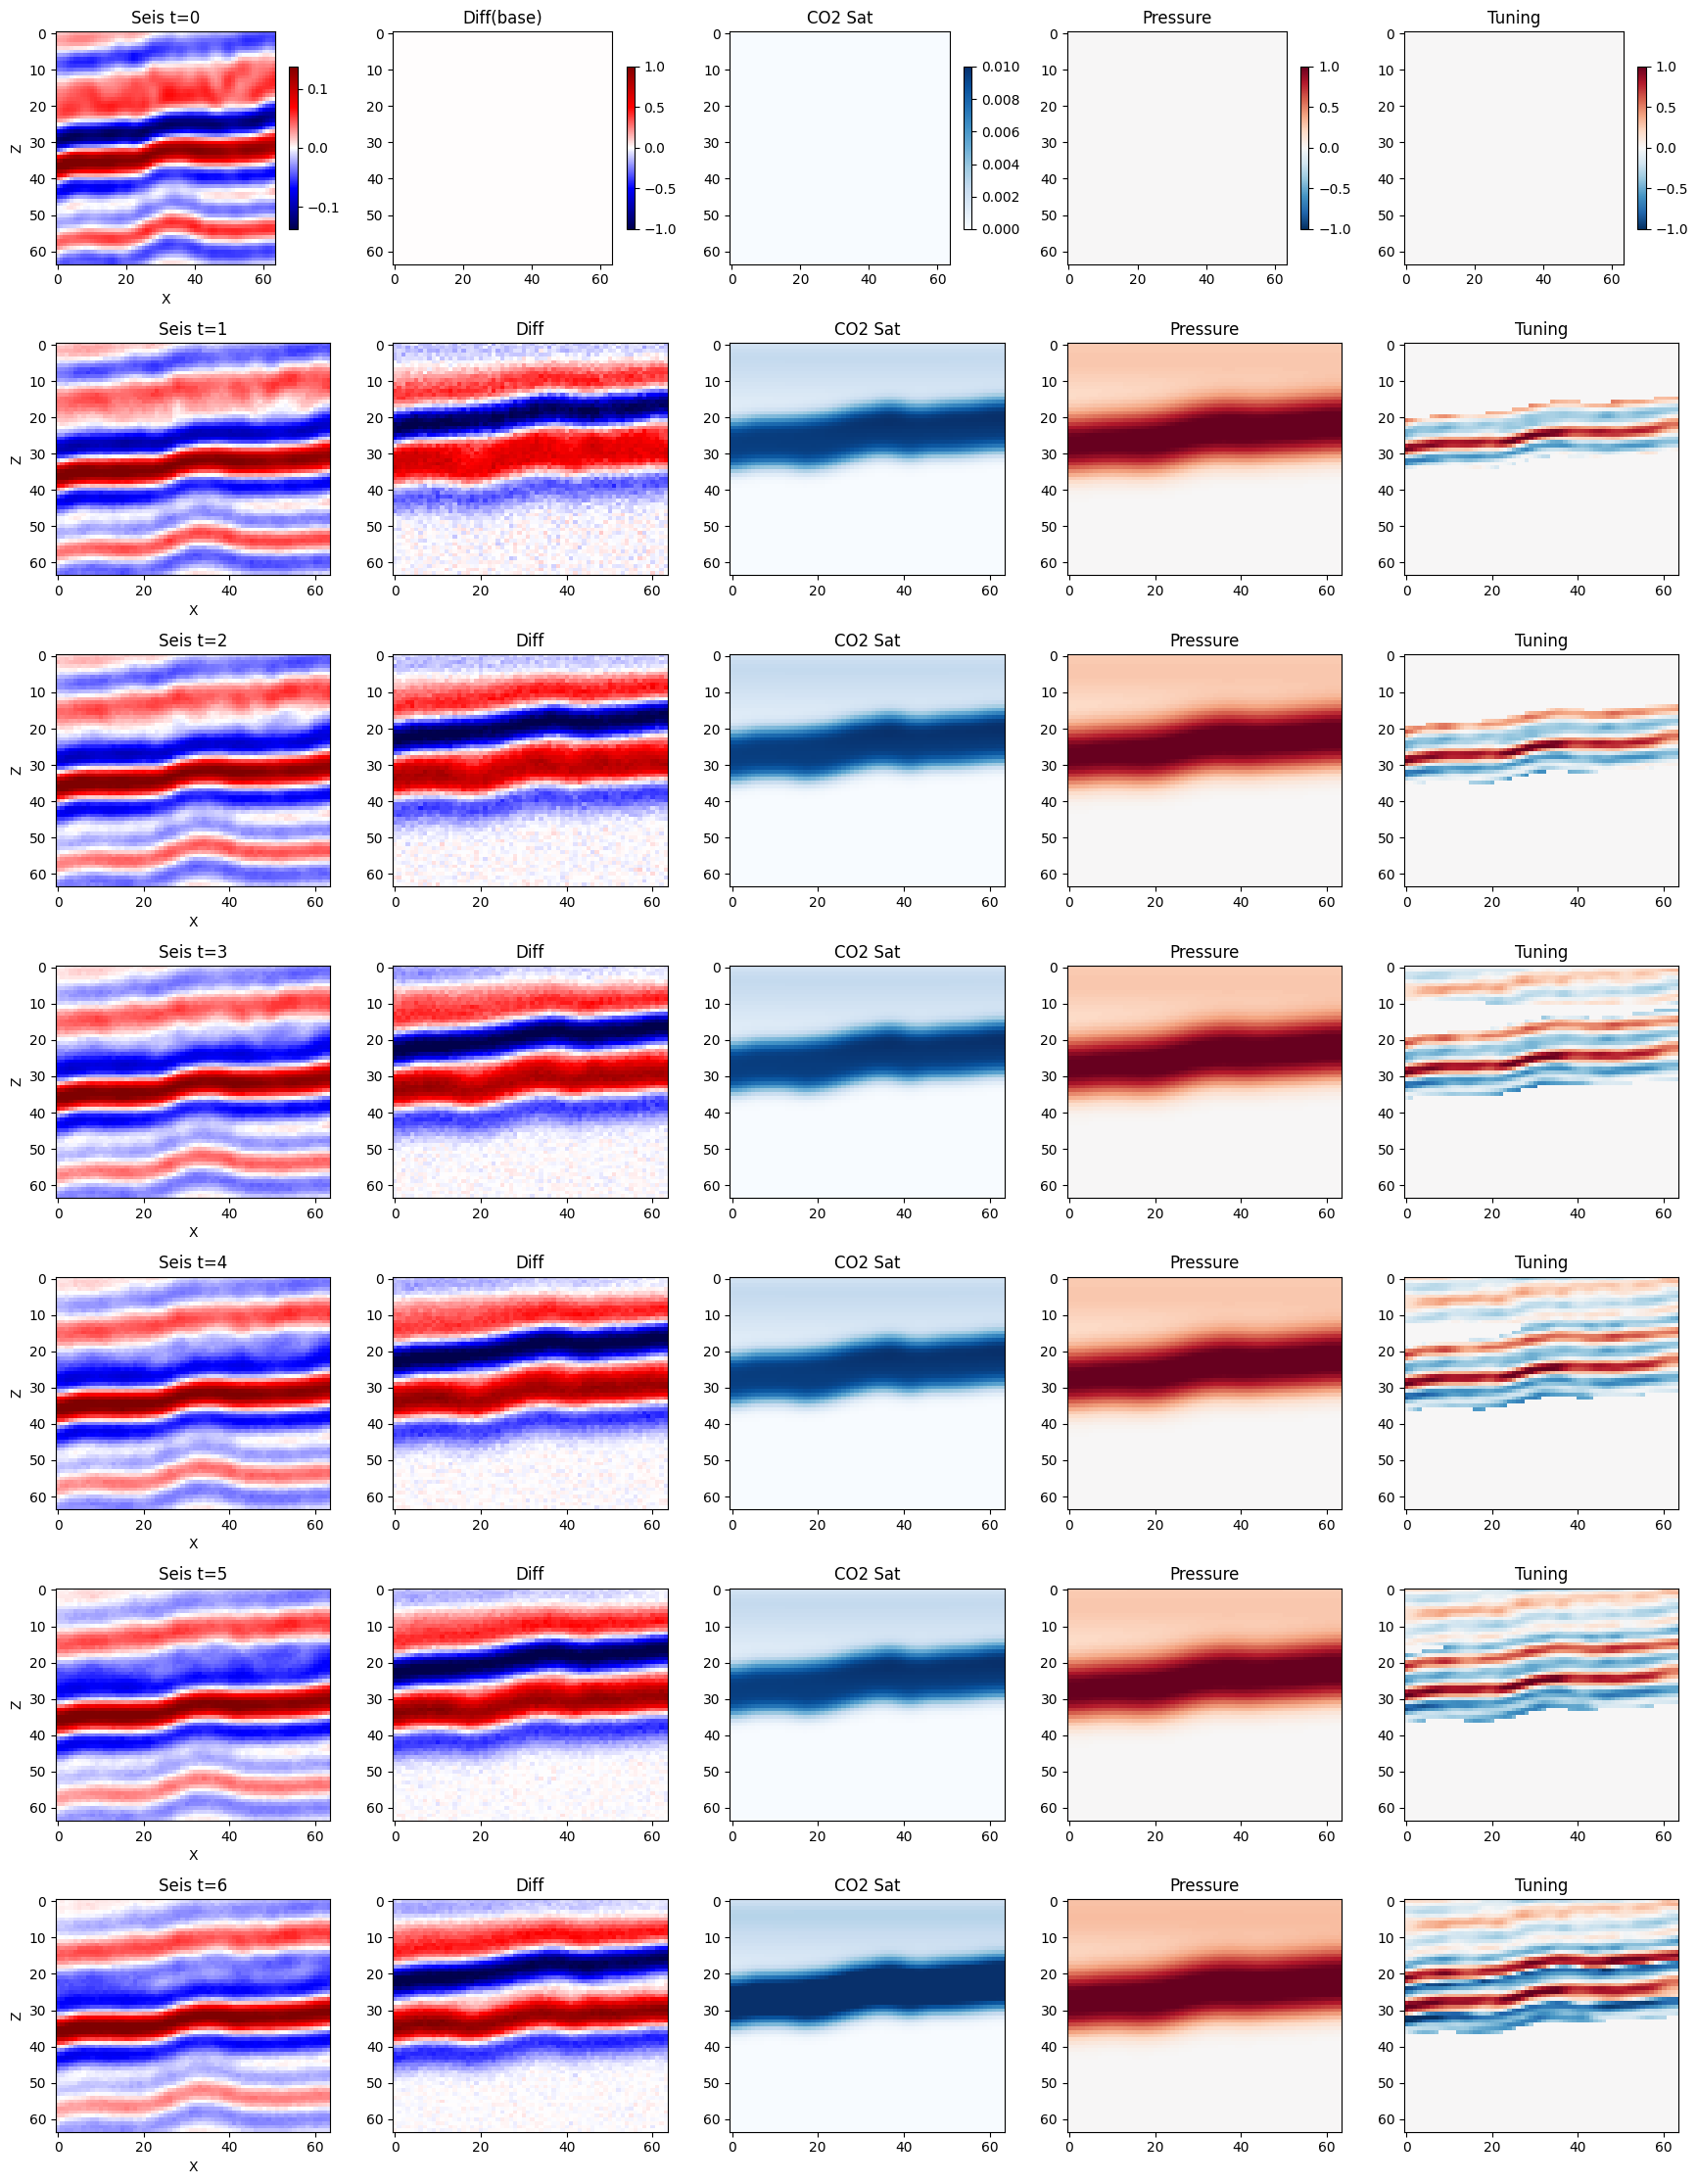

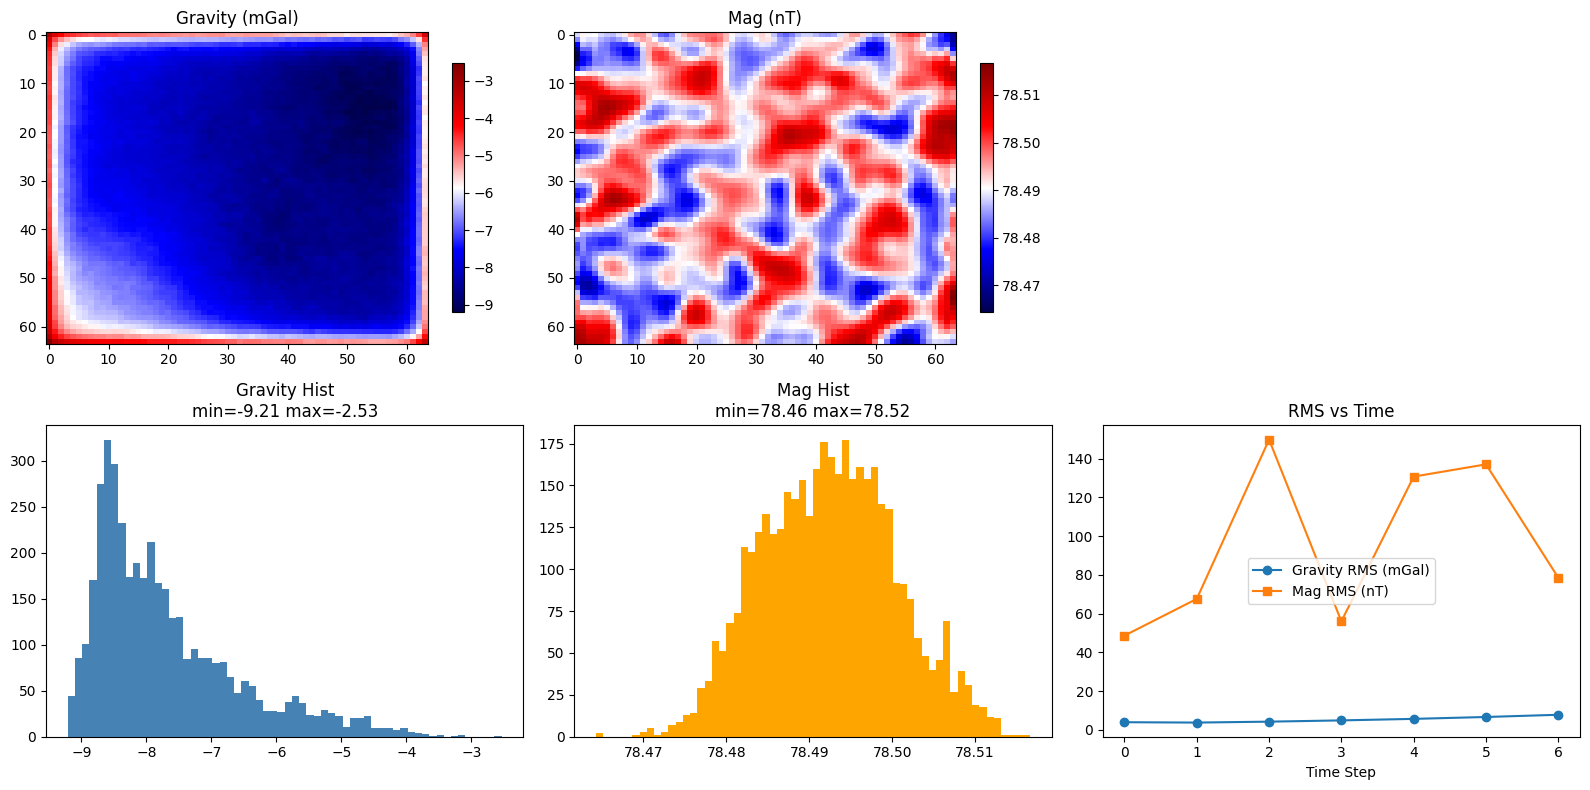

重力数值范围 (mGal): -9.209086418151855 -2.533266544342041
磁异常数值范围 (nT): 78.46429443359375 78.51661682128906
重力 RMS 序列: [np.float32(3.9338162), np.float32(3.7455347), np.float32(4.220626), np.float32(4.8700204), np.float32(5.6543727), np.float32(6.6308246), np.float32(7.7727194)]
磁异常 RMS 序列: [np.float32(48.620678), np.float32(67.56133), np.float32(149.75723), np.float32(56.013283), np.float32(130.66617), np.float32(136.99069), np.float32(78.49242)]


In [ ]:
#@title CO2时移单模型可视化与重力/磁异常数值验证
# -*- coding: utf-8 -*-
import os, json, re
import numpy as np
import matplotlib.pyplot as plt

data_root = output_root  # 与上一个 Cell 使用同一目录

# 选择一个模型索引 (注意格式 00000)
inspect_model_index = 401  #@param {type:"integer"}

save_format = "bin"  #@param ["bin","npz"]

# 可视化选项
plot_steps = 10        #@param {type:"integer"}
max_cols = 6
cmap_seis = 'seismic'
cmap_scalar = 'viridis'
cmap_div = 'RdBu_r'

def auto_find_file(prefix, suffix):
    fp = os.path.join(data_root, prefix + suffix)
    return fp if os.path.exists(fp) else None

def load_bin(fp, shape, dtype=np.float32):
    return np.fromfile(fp, dtype=dtype).reshape(shape)

def infer_shape_from_meta(meta_log_path, model_index):
    # 在 meta_log.jsonl 中搜索该模型记录
    if not os.path.exists(meta_log_path):
        raise FileNotFoundError("缺少 meta_log.jsonl 日志")
    with open(meta_log_path,'r',encoding='utf-8') as f:
        for line in f:
            if f'"model_index": {model_index}' in line:
                try:
                    rec = json.loads(line)
                    if 'shapes' in rec:
                        return rec
                except:
                    pass
    raise ValueError("未在日志中找到该模型形状信息")

meta_rec = infer_shape_from_meta(os.path.join(data_root,"meta_log.jsonl"),
                                 inspect_model_index)
shapes = meta_rec['shapes']
print("已从日志读取 shape 信息:", shapes)

prefix = f"co2_model_{inspect_model_index:05d}"

if save_format == 'bin':
    seis_fp = auto_find_file(prefix, "_seismic.bin")
    vp_fp   = auto_find_file(prefix, "_vp.bin")
    sat_fp  = auto_find_file(prefix, "_saturation.bin")
    prs_fp  = auto_find_file(prefix, "_pressure.bin")
    tun_fp  = auto_find_file(prefix, "_tuning.bin")
    gra_fp  = auto_find_file(prefix, "_gravity.bin")
    mag_fp  = auto_find_file(prefix, "_magnetic.bin")
    try:
        spatial_shape = tuple(shapes['vp_shape'][1:])  # e.g., (64, 64, 64)
        seismic_shape = (shapes['full_nt'],) + spatial_shape  # e.g., (7, 64, 64, 64)
    except KeyError:
        seismic_shape = tuple(shapes['seismic_shape'])



    vp_shape      = tuple(shapes['vp_shape'])
    sat_shape     = tuple(shapes['sat_shape'])
    prs_shape     = tuple(shapes['pressure_shape'])
    tun_shape     = tuple(shapes['tuning_shape'])
    gra_shape     = tuple(shapes['gravity_shape'])
    mag_shape     = tuple(shapes['magnetic_shape'])

    seismic = load_bin(seis_fp, correct_seismic_shape, np.float32)
    vp_seq  = load_bin(vp_fp,   vp_shape,   np.float32)
    sat_seq = load_bin(sat_fp,  sat_shape,  np.float32)
    prs_seq = load_bin(prs_fp,  prs_shape,  np.float32)
    tun_seq = load_bin(tun_fp,  tun_shape,  np.float32)
    gravity_seq = load_bin(gra_fp, gra_shape, np.float32)
    magnetic_seq= load_bin(mag_fp, mag_shape, np.float32)

else:
    npz_fp = os.path.join(data_root, f"{prefix}.npz")
    with np.load(npz_fp) as npz:
        seismic = npz['seismic']
        vp_seq  = npz['vp']
        sat_seq = npz['saturation']
        prs_seq = npz['pressure']
        tun_seq = npz['tuning']
        gravity_seq = npz['gravity']
        magnetic_seq= npz['magnetic']

nt, ny, nx, nz = seismic.shape
print(f"加载完成: seismic {seismic.shape}, gravity {gravity_seq.shape}, magnetic {magnetic_seq.shape}")

# 选取可视化的时间步
sel_steps = np.linspace(0, nt-1, min(plot_steps, nt), dtype=int).tolist()
inline_idx = ny // 2

# 基线
baseline_seis = seismic[0, inline_idx]
baseline_sat  = sat_seq[0, inline_idx]
baseline_prs  = prs_seq[0, inline_idx]

# 绘制
fig_rows = len(sel_steps)
fig_cols = 5  # Seis / Diff / CO2 / Pressure / Tuning
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols*3.5, fig_rows*3.2))
if fig_rows == 1:
    axes = axes.reshape(1,-1)

for r, step in enumerate(sel_steps):
    seis_slice = seismic[step, inline_idx]
    vmax = np.max(np.abs(seis_slice))*0.9 if np.max(np.abs(seis_slice))>0 else 1
    im0 = axes[r,0].imshow(seis_slice.T, cmap=cmap_seis, vmin=-vmax, vmax=vmax, aspect='auto')
    axes[r,0].set_title(f"Seis t={step}")
    axes[r,0].set_xlabel("X"); axes[r,0].set_ylabel("Z")
    if step == sel_steps[0]:
        fig.colorbar(im0, ax=axes[r,0], shrink=0.7)

    # Diff
    if step == 0:
        diff = np.zeros_like(seis_slice)
    else:
        diff = seis_slice - baseline_seis
    dv = np.max(np.abs(diff))*0.9 if np.max(np.abs(diff))>0 else 1
    im1 = axes[r,1].imshow(diff.T, cmap=cmap_seis, vmin=-dv, vmax=dv, aspect='auto')
    axes[r,1].set_title("Diff" if step>0 else "Diff(base)")
    if step == sel_steps[0]:
        fig.colorbar(im1, ax=axes[r,1], shrink=0.7)

    # CO2 Sat
    sat_slice = sat_seq[step, inline_idx]
    im2 = axes[r,2].imshow(sat_slice.T, cmap='Blues', vmin=0, vmax=max(0.01, sat_slice.max()), aspect='auto')
    axes[r,2].set_title("CO2 Sat")
    if step == sel_steps[0]:
        fig.colorbar(im2, ax=axes[r,2], shrink=0.7)

    # Pressure
    prs_slice = prs_seq[step, inline_idx]
    pv = np.max(np.abs(prs_slice))*0.9 if np.max(np.abs(prs_slice))>0 else 1
    im3 = axes[r,3].imshow(prs_slice.T, cmap=cmap_div, vmin=-pv, vmax=pv, aspect='auto')
    axes[r,3].set_title("Pressure")
    if step == sel_steps[0]:
        fig.colorbar(im3, ax=axes[r,3], shrink=0.7)

    # Tuning
    tun_slice = tun_seq[step, inline_idx]
    tv = np.max(np.abs(tun_slice))*0.9 if np.max(np.abs(tun_slice))>0 else 1
    im4 = axes[r,4].imshow(tun_slice.T, cmap=cmap_div, vmin=-tv, vmax=tv, aspect='auto')
    axes[r,4].set_title("Tuning")
    if step == sel_steps[0]:
        fig.colorbar(im4, ax=axes[r,4], shrink=0.7)

plt.tight_layout()
plt.show()

# 重力/磁异常数值统计与可视化 (最后时间步 / 或全部)
last_grav = gravity_seq[-1]
last_mag  = magnetic_seq[-1]

fig2, ax2 = plt.subplots(2,3, figsize=(16,8))
gim = ax2[0,0].imshow(last_grav, cmap='seismic', aspect='auto')
ax2[0,0].set_title("Gravity (mGal)")
plt.colorbar(gim, ax=ax2[0,0], shrink=0.8)

mim = ax2[0,1].imshow(last_mag, cmap='seismic', aspect='auto')
ax2[0,1].set_title("Mag (nT)")
plt.colorbar(mim, ax=ax2[0,1], shrink=0.8)

ax2[0,2].axis('off')

ax2[1,0].hist(last_grav.ravel(), bins=60, color='steelblue')
ax2[1,0].set_title(f"Gravity Hist\nmin={last_grav.min():.2f} max={last_grav.max():.2f}")

ax2[1,1].hist(last_mag.ravel(), bins=60, color='orange')
ax2[1,1].set_title(f"Mag Hist\nmin={last_mag.min():.2f} max={last_mag.max():.2f}")

# 时间维度的 RMS 轨迹（重力/磁 区域均值或 RMS）
g_rms_t = [np.sqrt(np.mean(g**2)) for g in gravity_seq]
m_rms_t = [np.sqrt(np.mean(m**2)) for m in magnetic_seq]
ax2[1,2].plot(g_rms_t, '-o', label='Gravity RMS (mGal)')
ax2[1,2].plot(m_rms_t, '-s', label='Mag RMS (nT)')
ax2[1,2].set_title("RMS vs Time")
ax2[1,2].legend()
ax2[1,2].set_xlabel("Time Step")

plt.tight_layout()
plt.show()

print("重力数值范围 (mGal):", float(last_grav.min()), float(last_grav.max()))
print("磁异常数值范围 (nT):", float(last_mag.min()), float(last_mag.max()))
print("重力 RMS 序列:", g_rms_t)
print("磁异常 RMS 序列:", m_rms_t)


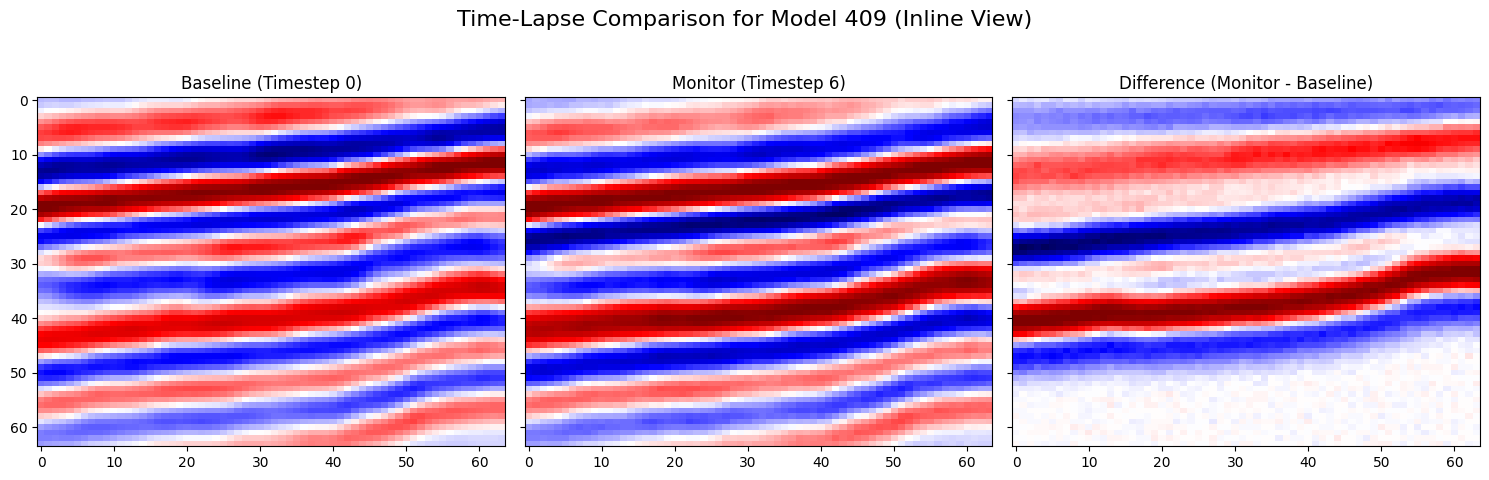

Button(button_style='success', description='Save to PDF', style=ButtonStyle())

Figure saved to: /content/drive/MyDrive/SeismicWorld/dataset/CO2/model_409_timelapse_comparison.pdf


In [ ]:
#@title 绘制SCI论文图-co2
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from IPython.display import display

def load_metadata(log_path):
    """Loads the JSONL log file into a dictionary mapping model_index to metadata."""
    metadata_map = {}
    if not os.path.exists(log_path):
        print(f"Error: Log file not found at {log_path}")
        return None
    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                meta = json.loads(line)
                if "model_index" in meta and "error" not in meta:
                    metadata_map[meta["model_index"]] = meta
            except json.JSONDecodeError:
                print(f"Warning: Could not parse line in log file: {line}")
                continue
    return metadata_map

def plot_seismic_diversity(output_root, model_index_start, num_models_to_plot, slice_type='inline', time_step_to_plot=0):
    """
    Scans a range of models, reads their seismic data, and plots a specific slice
    from each to showcase dataset diversity.
    """
    log_path = os.path.join(output_root, "meta_log.jsonl")
    metadata_map = load_metadata(log_path)

    if not metadata_map:
        print("Could not load metadata. Aborting plot.")
        return

    # --- Setup Subplots ---
    if num_models_to_plot <= 0:
        print("Number of models to plot must be greater than 0.")
        return
    cols = int(math.ceil(math.sqrt(num_models_to_plot)))
    rows = int(math.ceil(num_models_to_plot / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3), squeeze=False)
    axes = axes.flatten()

    plot_count = 0
    # Get a sorted list of available model indices
    available_indices = sorted([idx for idx in metadata_map.keys() if idx >= model_index_start])

    # Determine the actual models we will plot
    models_to_plot = available_indices[:num_models_to_plot]

    for i, model_idx in enumerate(models_to_plot):
        ax = axes[i]
        meta = metadata_map[model_idx]
        save_format = meta.get('save_format', 'bin')
        prefix = f"co2_model_{model_idx:05d}"

        try:
            # --- Load Seismic Data ---
            if save_format == 'bin':
                seismic_path = os.path.join(output_root, f"{prefix}_seismic.bin")
                if not os.path.exists(seismic_path):
                     raise FileNotFoundError(f"Seismic file not found: {seismic_path}")

                # **FIXED LOGIC**: Use the 'shapes' dictionary from the metadata, as it
                # reflects the true dimensions of the array *after* any resampling.
                seismic_shape = tuple(meta['shapes']['seismic_shape'])

                seismic_data = np.fromfile(seismic_path, dtype=np.float32)

                # Add a verification step for robustness
                expected_size = np.prod(seismic_shape)
                if seismic_data.size != expected_size:
                    raise ValueError(f"Data size in file ({seismic_data.size}) does not match metadata shape {seismic_shape} (expected {expected_size})")

                seismic_data = seismic_data.reshape(seismic_shape)

            elif save_format == 'npz':
                npz_path = os.path.join(output_root, f"{prefix}.npz")
                if not os.path.exists(npz_path):
                     raise FileNotFoundError(f"NPZ file not found: {npz_path}")
                with np.load(npz_path) as data:
                    seismic_data = data['seismic']
            else:
                raise ValueError(f"Unsupported save_format: {save_format}")

            # --- Extract Slice ---
            nt, ny, nx, nz = seismic_data.shape
            # Ensure time_step_to_plot is valid
            time_step = max(0, min(time_step_to_plot, nt - 1))

            if slice_type == 'inline':
                slice_idx = ny // 2
                slice_data = seismic_data[time_step, slice_idx, :, :].T
            elif slice_type == 'xline':
                slice_idx = nx // 2
                slice_data = seismic_data[time_step, :, slice_idx, :].T
            elif slice_type == 'tslice':
                slice_idx = nz // 2
                slice_data = seismic_data[time_step, :, :, slice_idx]
            else:
                raise ValueError("slice_type must be 'inline', 'xline', or 'tslice'")

            # --- Plotting ---
            vmax = np.percentile(np.abs(slice_data), 99)
            if vmax < 1e-9: vmax = 1.0
            ax.imshow(slice_data, cmap='seismic', vmin=-vmax, vmax=vmax, aspect='auto')
            ax.set_title(f"Model {model_idx} (T={time_step})")
            plot_count += 1

        except (FileNotFoundError, ValueError, KeyError) as e:
            ax.text(0.5, 0.5, f'Model {model_idx}\n(Error Loading)', ha='center', va='center', fontsize=9, color='red')
            print(f"Could not plot model {model_idx}: {e}")

        finally:
            ax.set_xticks([])
            ax.set_yticks([])

    # Hide any unused subplots
    for i in range(len(models_to_plot), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(f'Seismic Diversity: Displaying Models from Index {model_index_start}', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_model_timelapse_comparison(output_root, model_index, slice_type='inline'):
    """
    Loads a single model and creates a 3-panel plot showing the baseline,
    final timestep, and the difference, with a button to save the figure as a PDF.

    Args:
        output_root (str): The root directory where the dataset is saved.
        model_index (int): The index of the model to plot.
        slice_type (str): The type of slice to plot ('inline', 'xline', 'tslice').
    """
    log_path = os.path.join(output_root, "meta_log.jsonl")
    metadata_map = load_metadata(log_path)

    if not metadata_map or model_index not in metadata_map:
        print(f"Error: Metadata for model {model_index} not found in {log_path}")
        return

    meta = metadata_map[model_index]
    save_format = meta.get('save_format', 'bin')
    prefix = f"co2_model_{model_index:05d}"

    try:
        # --- Load the full seismic data cube ---
        if save_format == 'bin':
            seismic_path = os.path.join(output_root, f"{prefix}_seismic.bin")
            seismic_shape = tuple(meta['shapes']['seismic_shape'])
            seismic_data = np.fromfile(seismic_path, dtype=np.float32).reshape(seismic_shape)
        elif save_format == 'npz':
            npz_path = os.path.join(output_root, f"{prefix}.npz")
            with np.load(npz_path) as data:
                seismic_data = data['seismic']
        else:
            raise ValueError(f"Unsupported save_format: {save_format}")

        nt, ny, nx, nz = seismic_data.shape
        if nt < 2:
            print(f"Model {model_index} has only {nt} timestep(s). Cannot create a time-lapse comparison.")
            return

        # --- Get baseline, monitor, and difference data ---
        baseline = seismic_data[0]
        monitor = seismic_data[-1] # -1 always gets the last item
        difference = monitor - baseline

        # --- Extract the specific slice from each cube ---
        if slice_type == 'inline':
            slice_idx = ny // 2
            baseline_slice = baseline[slice_idx, :, :].T
            monitor_slice = monitor[slice_idx, :, :].T
            difference_slice = difference[slice_idx, :, :].T
        elif slice_type == 'xline':
            slice_idx = nx // 2
            baseline_slice = baseline[:, slice_idx, :].T
            monitor_slice = monitor[:, slice_idx, :].T
            difference_slice = difference[:, slice_idx, :].T
        else: # tslice
            slice_idx = nz // 2
            baseline_slice = baseline[:, :, slice_idx]
            monitor_slice = monitor[:, :, slice_idx]
            difference_slice = difference[:, :, slice_idx]

        # --- Plotting ---
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

        # Determine color limits for baseline and monitor for a fair comparison
        vmax = np.percentile(np.abs(baseline_slice), 99)
        if vmax < 1e-9: vmax = 1.0

        # Determine color limits for the difference plot
        diff_vmax = np.percentile(np.abs(difference_slice), 99)
        if diff_vmax < 1e-9: diff_vmax = 1.0

        axes[0].imshow(baseline_slice, cmap='seismic', vmin=-vmax, vmax=vmax, aspect='auto')
        axes[0].set_title(f'Baseline (Timestep 0)')

        axes[1].imshow(monitor_slice, cmap='seismic', vmin=-vmax, vmax=vmax, aspect='auto')
        axes[1].set_title(f'Monitor (Timestep {nt-1})')

        axes[2].imshow(difference_slice, cmap='seismic', vmin=-diff_vmax, vmax=diff_vmax, aspect='auto')
        axes[2].set_title('Difference (Monitor - Baseline)')

        fig.suptitle(f'Time-Lapse Comparison for Model {model_index} ({slice_type.capitalize()} View)', fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        # --- Create and display the save button ---
        save_button = widgets.Button(description="Save to PDF", button_style='success')

        def on_save_button_clicked(b):
            pdf_filename = os.path.join(output_root, f"model_{model_index}_timelapse_comparison.pdf")
            fig.savefig(pdf_filename, format='pdf', bbox_inches='tight')
            print(f"Figure saved to: {pdf_filename}")

        save_button.on_click(on_save_button_clicked)

        # Display the plot first, then the button underneath
        plt.show()
        display(save_button)

    except (FileNotFoundError, ValueError, KeyError) as e:
        print(f"An error occurred while processing model {model_index}: {e}")

output_root = "/content/drive/MyDrive/SeismicWorld/dataset/CO2"

# Plot a comparison for a single model
plot_model_timelapse_comparison(
    output_root=output_root,
    model_index=409, # Choose any model index you want to inspect
    slice_type='inline'
)


# print("Plotting baseline seismic (time_step_to_plot=0)")
# plot_seismic_diversity(
#     output_root=output_root,
#     model_index_start=400,
#     num_models_to_plot=9,
#     slice_type='inline',
#     time_step_to_plot=0
# )

# plot_seismic_diversity(
#     output_root=output_root,
#     model_index_start=400,
#     num_models_to_plot=9,
#     slice_type='inline',
#     time_step_to_plot=-1
# )


In [ ]:
#@title load CHARM-Distillation
import os
import json
import numpy as np
import torch
from tqdm.notebook import tqdm
import traceback

# --- Configuration ---
# The root directory where your dataset is stored.
output_root = "/content/drive/MyDrive/SeismicWorld/dataset/CO2"
# The range of models you want to consolidate.
model_index_start = 400
model_index_end = 409 # Inclusive
# The name for the final consolidated file.
output_pth_file = f"seismic_data_{model_index_start}-{model_index_end}.pth"

# --- Main Logic ---
print(f"Starting consolidation for models {model_index_start} to {model_index_end}.")

# 1. Load Metadata
log_path = os.path.join(output_root, "meta_log.jsonl")
metadata_map = {}
if not os.path.exists(log_path):
    print(f"FATAL: Log file not found at {log_path}")
else:
    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                meta = json.loads(line)
                if "model_index" in meta and "error" not in meta:
                    metadata_map[meta["model_index"]] = meta
            except json.JSONDecodeError:
                print(f"Warning: Could not parse line in log file: {line.strip()}")
                continue
    print(f"Successfully loaded metadata for {len(metadata_map)} models.")

# 2. Iterate, Load Data, and Convert to Tensors
all_seismic_data = {}
models_to_process = range(model_index_start, model_index_end + 1)

if metadata_map: # Proceed only if metadata was loaded
    for model_idx in tqdm(models_to_process, desc="Processing models"):
        if model_idx not in metadata_map:
            print(f"Warning: No metadata found for model {model_idx}. Skipping.")
            continue

        try:
            meta = metadata_map[model_idx]
            save_format = meta.get('save_format', 'bin') # Default to 'bin' if not specified
            prefix = f"co2_model_{model_idx:05d}"
            seismic_data_np = None

            # --- Load based on format ---
            if save_format == 'bin':
                seismic_path = os.path.join(output_root, f"{prefix}_seismic.bin")
                if not os.path.exists(seismic_path):
                     raise FileNotFoundError(f"Seismic .bin file not found: {seismic_path}")

                # Use the shape from metadata to correctly reshape the flat binary array
                seismic_shape = tuple(meta['shapes']['seismic_shape'])
                seismic_data_np = np.fromfile(seismic_path, dtype=np.float32)

                # Verification
                expected_size = np.prod(seismic_shape)
                if seismic_data_np.size != expected_size:
                    raise ValueError(f"Data size in file ({seismic_data_np.size}) does not match metadata shape {seismic_shape} (expected {expected_size})")

                seismic_data_np = seismic_data_np.reshape(seismic_shape)

            elif save_format == 'npz':
                npz_path = os.path.join(output_root, f"{prefix}.npz")
                if not os.path.exists(npz_path):
                     raise FileNotFoundError(f"Seismic .npz file not found: {npz_path}")
                with np.load(npz_path) as data:
                    if 'seismic' not in data:
                        raise KeyError("'seismic' key not found in the .npz file.")
                    seismic_data_np = data['seismic']
            else:
                print(f"Warning: Unsupported save_format '{save_format}' for model {model_idx}. Skipping.")
                continue

            # --- Convert to PyTorch Tensor and store in dictionary ---
            if seismic_data_np is not None:
                all_seismic_data[model_idx] = torch.from_numpy(seismic_data_np)

        except (FileNotFoundError, ValueError, KeyError, Exception) as e:
            print(f"Error processing model {model_idx}: {e}")
            traceback.print_exc()
            continue

# 3. Save the Consolidated Dictionary to a .pth file
if not all_seismic_data:
    print("\nNo data was successfully loaded. The output .pth file will not be created.")
else:
    output_path = os.path.join(output_root, output_pth_file)
    try:
        torch.save(all_seismic_data, output_path)
        print(f"\n✅ Successfully consolidated {len(all_seismic_data)} models.")
        print(f"All seismic data saved to: {output_path}")
    except Exception as e:
        print(f"\n❌ An error occurred while saving the final .pth file: {e}")



Starting consolidation for models 400 to 409.
Successfully loaded metadata for 410 models.


Processing models:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Successfully consolidated 10 models.
All seismic data saved to: /content/drive/MyDrive/SeismicWorld/dataset/CO2/seismic_data_400-409.pth


#oil

In [ ]:
#@title 批量构建 “油气运移 & 聚集” 时移多物理场数据集（含断点续跑增强）

"""
------------------------------------------------------------------
主要输出 (每个模型随机 nt 步):
  seismic[nt, ny, nx, nz]
  vp_seq[nt, ny, nx, nz]
  so_seq / sg_seq / sw_seq
  pressure_seq
  rc_seq (可选是否单独输出；这里直接通过再计算 seismic)
  tuning_seq (可选)
  gravity_seq (若选择每步或最终计算)
  goc_track[nt] / owc_track[nt]  (接触面深度随时间)
------------------------------------------------------------------
快速物理假设:
  1. 初始：下部含水，上部开始聚集油，再向上/向侧聚集气；Sw 初始较高随后被 So/Sg 替换。
  2. Gas-Oil Contact (GOC) 随时间上移或略振荡；Oil-Water Contact (OWC) 随时间缓慢下移 (油气向上聚集)。
  3. 饱和度垂向分布采用基于接触面的 Logistic / Tanh 组合+侧向衰减 (水平方向使用简化高斯或均匀)。
  4. 速度变化由：ΔVp ≈ -(a_o * ΔSo + a_g * ΔSg) * Vp0 + p_coeff * ΔP * Vp0
  5. 密度变化：ρ_new = ρ0 + (dr_o * So + dr_g * Sg + dr_w * Sw)，其中 dr_x 为相对对比；或仅根据 So/Sg 相对降低。
  6. 可选薄层调谐：对存在油气饱和度变化层段局部 1D 纵向平滑后与原 RC 混合。
------------------------------------------------------------------
"""
import os, json, time, math, random, gc, traceback
from datetime import datetime
from pathlib import Path
import numpy as np
from tqdm import tqdm

# ======================= 全局输出目录与配置 =======================
output_root = "/content/drive/MyDrive/SeismicWorld/dataset/OIL"  # 修改为你的输出路径
os.makedirs(output_root, exist_ok=True)

save_format = "bin"          # "bin" or "npz"
npz_compress = True

# 原语义：本次准备尝试生成多少个（若使用 target_total_models 可忽略或设 None）
total_models = 1000       #@param
# 起始模型索引（非自动模式下生效）
model_index_start = 0
small_run = False            # 测试快速运行
global_seed = 3035

# 时间步随机范围
nt_min, nt_max = 20, 30

# 是否保存每个时间步重力/磁异常 (油气运移重力变化较弱，可仅最终步)
save_gravity_each_step = False
save_magnetic_each_step = False

# 重采样/裁剪 Z (与 CO2 脚本一致，保证 shape 兼容)
resample_z_range = (200, 1480)

# 观测高度采样
gravity_height_range = (20.0, 150.0)
magnetic_height_range = (5.0, 40.0)
padding_factor_choices = [1, 2]

# ---------------------- 依赖: 需确保 GeoModel 已被导入 ----------------------
# from your_module import GeoModel

# === Resume >>> 新增：断点续跑控制参数 ===
# resume_mode 取值:
#   'none'      : 使用给定 model_index_start 连续生成 total_models 个
#   'auto'      : 自动读取日志/文件找最大成功 index，从其后续跑，结合 target_total_models 只补缺口
#   'from_log'  : 仅重试日志里失败的模型
#   'from_files': 仅通过扫描文件前缀推断最大 index 后续跑（不读失败列表）
resume_mode = 'auto'   # 可选 'none','auto','from_log','from_files'

# 期望目录内最终成功模型总数 (优先级高于 total_models；若为 None 则使用 total_models 作为本次数量)
target_total_models = 1000   # 例如希望累计达到 1000；若不需要则设为 None

# 是否覆盖已存在同前缀文件（当 resume_mode 不是 'from_log' 且可能重复时）
overwrite_existing = True #@param

# 遇到失败是否立刻重试（简单一次），可减少偶发 IO 失败影响
immediate_retry_once = False
# === Resume <<<

# ======================= 参数采样函数 =======================
def sample_velocity_params(rng: random.Random):
    vp_list = [
        (rng.uniform(2800,3200), rng.uniform(3400,3800)),
        (rng.uniform(3600,4000), rng.uniform(4500,5200)),
        (rng.uniform(5000,5600), rng.uniform(6000,6500))
    ]
    return dict(
        h_layer_range=[60*rng.uniform(0.8,1.2), 120*rng.uniform(0.8,1.2)],
        fm_list=[0.3,0.6],
        vp_list=vp_list,
        vp_diff=rng.uniform(400,600),
        vp_disturb=rng.uniform(200,380),
        smooth=False
    )

def sample_channel_params_for_reservoir(rng: random.Random, idx: int):
    static_prob = 0.85
    if rng.random() < static_prob:
        n_iter_range = [1,1]
    else:
        n_iter_range = [rng.randint(2,4), rng.randint(5,8)]
        if n_iter_range[0] > n_iter_range[1]:
            n_iter_range = [1,1]
    W_range = (rng.uniform(180,260), rng.uniform(260,340))
    if W_range[0] > W_range[1]:
        W_range = (180,260)
    D_range = (rng.uniform(14,20), rng.uniform(18,26))
    strike_center = (idx*53) % 360
    strike_span = rng.uniform(40,100)
    strike_range = [(strike_center - strike_span/2)%360, (strike_center + strike_span/2)%360]
    Z_pos_range = [rng.uniform(0.35,0.55), rng.uniform(0.60,0.80)]
    Z_pos_range.sort()
    return dict(
        N=1,
        X_pos_range=[0.0, rng.uniform(0.05,0.1)],
        Y_pos_range=[rng.uniform(0.15,0.35), rng.uniform(0.65,0.85)],
        Z_pos_range=Z_pos_range,
        strike_range=strike_range,
        W_range=[int(W_range[0]), int(W_range[1])],
        D_range=[int(D_range[0]), int(D_range[1])],
        Wx_range=[int(W_range[0]*1.3), int(W_range[1]*1.3)],
        Dx_range=[int(D_range[0]*1.1), int(D_range[1]*1.15)],
        kl_range=[40,55],
        Cf_range=[0.05,0.08],
        n_iter_range=n_iter_range,
        epsilon_range=[0.35,0.55],
        incision_mode='random',
        kv=0, aggr=0,
        save_iter=int(1e9),
        show_migration=False,
        seed=None,
        instance_label=False,
        mute=True
    )

def sample_density_params(rng: random.Random):
    return dict(method='gardner',
                params={'a':0.31,'b':0.25},
                channel_density_contrast=(rng.uniform(-0.12,-0.05), rng.uniform(0.01,0.05)),
                mute=True)

def sample_magnetic_params(rng: random.Random, horizons):
    fm_list = [0.3 + rng.uniform(-0.02,0.02), 0.6 + rng.uniform(-0.02,0.02)]
    fm_list = [max(0.05,min(0.9,v)) for v in fm_list]
    k_list = [
        (rng.uniform(3e-5,6e-5), rng.uniform(1.0e-4,2.0e-4)),
        (rng.uniform(1.5e-4,3e-4), rng.uniform(5e-4,8e-4)),
        (rng.uniform(7e-4,1.2e-3), rng.uniform(1.5e-3,2.8e-3))
    ]
    facies_k = {1:(1e-5,5e-5),2:(1e-4,7e-4),3:(2e-4,1e-3),4:(1e-5,2e-5)}
    return dict(
        kappa_list=k_list,
        fm_list=fm_list,
        kappa_disturb=rng.uniform(5e-5,1.5e-4),
        facies_kappa=facies_k,
        background_kappa=(2e-5,1e-4),
        smooth=True,
        sigma=rng.uniform(1.0,1.8),
        seed=None,
        mute=True
    )

def sample_hc_migration_timelapse_params(rng: random.Random, nt: int):
    return dict(
        nt=nt,
        goc_rise=rng.uniform(120, 220),
        owc_drop=rng.uniform(80, 150),
        max_sg_center=rng.uniform(0.45, 0.75),
        max_so_center=rng.uniform(0.65, 0.90),
        pressure_mode=rng.choice(['linear','late']),
        tuning_factor=rng.uniform(2.2, 3.5),
        noise_level=rng.uniform(0.005, 0.012),
        wavelet_type='ricker',
        f_ricker=rng.uniform(16, 22),
        dt=0.002
    )

# ======================= 核心：油气运移快速模拟函数 =======================
def simulate_hc_migration_timelapse_fast(
    gm,
    nt,
    goc_rise,
    owc_drop,
    max_sg_center,
    max_so_center,
    pressure_mode,
    tuning_factor,
    noise_level,
    wavelet_type='ricker',
    f_ricker=28,
    dt=0.002,
    seed=None,
    compute_potential='final',
    a_o=0.12,
    a_g=0.22,
    p_coeff=0.05,
    dr_o=-0.15,
    dr_g=-0.35,
    dr_w=0.0,
    lateral_patch=True,
    lateral_patch_sigma=12,
    rc_boost=True,
    rc_boost_cap=1.8,
    time_progressive_sensitivity=True
):
    from scipy.ndimage import gaussian_filter, gaussian_filter1d
    rng = np.random.default_rng(seed)

    vp0 = gm.vp.copy()
    if gm.rc is None:
        gm.compute_rc(mute=True)
    gm.make_synseis(wavelet_type=wavelet_type, f_ricker=f_ricker, dt=dt, mute=True)
    rc0 = gm.rc.copy()
    rho0 = gm.rho.copy() if gm.rho is not None else None
    gravity0 = getattr(gm,'gravity', None)
    magnetic0 = getattr(gm,'magnetic_anomaly', None)

    ny, nx, nz = vp0.shape
    z_vals = np.arange(nz)*gm.dZ + gm.Zmin
    z_min, z_max = z_vals.min(), z_vals.max()
    span = z_max - z_min

    goc0 = z_min + 0.45*span
    owc0 = z_min + 0.55*span

    if lateral_patch:
        rand_field = rng.uniform(0.7, 1.3, size=(ny, nx))
        rand_field = gaussian_filter(rand_field, sigma=lateral_patch_sigma)
        rand_field = (rand_field - rand_field.min())/(rand_field.max()-rand_field.min())
        lateral_amp = 1.0 + 0.8*rand_field
        lateral_amp3d = lateral_amp[:, :, None]
    else:
        lateral_amp3d = 1.0

    out = []
    goc_track = [goc0]
    owc_track = [owc0]

    out.append(dict(
        time_step=0,
        vp=vp0.copy(),
        rc=rc0.copy(),
        seismic=gm.seismic.copy(),
        sg=np.zeros_like(vp0),
        so=np.zeros_like(vp0),
        sw=np.ones_like(vp0),
        pressure=np.zeros_like(vp0),
        goc_depth=goc0,
        owc_depth=owc0,
        gravity=gravity0,
        magnetic=magnetic0
    ))

    z_grid_1x1 = z_vals.reshape(1,1,nz)

    for ti in range(1, nt):
        frac = ti/(nt-1)
        a_o_eff = a_o * (1 + 0.5*frac) if time_progressive_sensitivity else a_o
        a_g_eff = a_g * (1 + 0.6*frac) if time_progressive_sensitivity else a_g
        p_coeff_eff = p_coeff * (1 + 0.4*frac) if time_progressive_sensitivity else p_coeff

        goc_t = goc0 - goc_rise*frac
        owc_t = owc0 + owc_drop*frac
        if goc_t < z_min + gm.dZ: goc_t = z_min + gm.dZ
        if owc_t > z_max - gm.dZ: owc_t = z_max - gm.dZ
        if goc_t >= owc_t:
            mid = 0.5*(goc_t + owc_t)
            goc_t = mid - gm.dZ
            owc_t = mid + gm.dZ
        goc_track.append(goc_t)
        owc_track.append(owc_t)

        thickness = max(owc_t - goc_t, 30.0)
        tg = max(0.6*thickness, 15.0)
        to = tg

        sg_prof = max_sg_center * frac * (1.0/(1.0 + np.exp((z_grid_1x1 - goc_t)/(tg*0.18))))
        so_prof = max_so_center * (1 - np.exp(-2.2*frac)) \
                  * (1.0/(1.0 + np.exp((goc_t - z_grid_1x1)/(to*0.22)))) \
                  * (1.0/(1.0 + np.exp((z_grid_1x1 - owc_t)/(to*0.22))))

        total = sg_prof + so_prof
        over = total > 1.0
        if np.any(over):
            sg_prof[over] *= 1.0/total[over]
            so_prof[over] *= 1.0/total[over]
        sw_prof = 1.0 - (sg_prof + so_prof)
        sw_prof[sw_prof < 0] = 0

        Sg = (sg_prof * lateral_amp3d).clip(0, 0.9).astype(np.float32)
        So = (so_prof * lateral_amp3d).clip(0, 0.95).astype(np.float32)
        total2 = Sg + So
        adj = total2 > 0.98
        if np.any(adj):
            Sg[adj] *= 0.98/total2[adj]
            So[adj] *= 0.98/total2[adj]
        Sw = (1.0 - (Sg + So)).astype(np.float32)

        if pressure_mode == 'linear':
            p_scalar = 0.5*frac
        elif pressure_mode == 'mild':
            p_scalar = 0.4*np.sqrt(frac)
        else:
            p_scalar = 0.6*frac**2
        pressure_field = p_scalar * np.ones_like(vp0, dtype=np.float32)

        dv = -(a_o_eff*So + a_g_eff*Sg)*vp0 + p_coeff_eff*pressure_field*vp0
        vp_new = vp0 + dv

        gm.vp = vp_new
        gm.compute_rc(mute=True, time_lapse=True)

        rc_orig = gm.rc.copy()
        rc_sm = gaussian_filter1d(rc_orig, sigma=tuning_factor, axis=2)
        fluid_mask = ((So + Sg) > 0.05).any(axis=2)
        gm.rc = np.where(fluid_mask[:,:,None], 0.6*rc_orig + 0.4*rc_sm, rc_orig)

        if rc_boost:
            boost = 1.0 + (So + 1.2*Sg)
            boost = np.clip(boost, 1.0, rc_boost_cap)
            gm.rc *= boost

        gm.make_synseis(wavelet_type=wavelet_type, f_ricker=f_ricker, dt=dt, mute=True)

        if noise_level > 0:
            gm.seismic += rng.normal(0, noise_level*np.std(gm.seismic), gm.seismic.shape).astype(np.float32)

        gravity_map = None
        magnetic_map = None
        if (rho0 is not None) and (compute_potential in ('each','final')):
            gm.rho = rho0 + dr_o*So + dr_g*Sg + dr_w*Sw
            if compute_potential == 'each' or (compute_potential == 'final' and ti == nt-1):
                gm.compute_gravity(height=50.0, padding_factor=1, mute=True)
                gravity_map = gm.gravity.copy()
        if magnetic0 is not None:
            if compute_potential == 'each':
                magnetic_map = magnetic0.copy()
            elif compute_potential == 'final' and ti == nt-1:
                magnetic_map = magnetic0.copy()

        out.append(dict(
            time_step=ti,
            vp=vp_new.copy(),
            rc=gm.rc.copy(),
            seismic=gm.seismic.copy(),
            sg=Sg,
            so=So,
            sw=Sw,
            pressure=pressure_field,
            goc_depth=goc_t,
            owc_depth=owc_t,
            gravity=gravity_map,
            magnetic=magnetic_map
        ))

    gm.vp = vp0
    gm.rc = rc0
    return out, np.array(goc_track, dtype=np.float32), np.array(owc_track, dtype=np.float32)

# === Resume >>> 辅助函数：解析日志、扫描文件、确定续跑索引 ===
def _parse_existing_from_log(log_path):
    success_indices = set()
    failed_indices = set()
    if not os.path.isfile(log_path):
        return success_indices, failed_indices
    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            line=line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except:
                continue
            idx = obj.get("model_index")
            if idx is None:
                continue
            if 'error' in obj:
                failed_indices.add(idx)
            elif obj.get('skipped'):
                # 跳过的不算成功也不算失败
                pass
            else:
                # 标记成功：有 type=hydrocarbon_migration 或 shapes 字段
                if obj.get("type") == "hydrocarbon_migration" or "shapes" in obj:
                    success_indices.add(idx)
    return success_indices, failed_indices

def _scan_existing_files(prefix_root):
    indices = set()
    for fname in os.listdir(prefix_root):
        if fname.startswith("hc_model_"):
            # hc_model_00012_seismic.bin 或 .npz
            try:
                core = fname.split("_")[2]  # model + index + rest
            except:
                continue
            # 更简单方式：hc_model_00012
            try:
                idx_part = fname[len("hc_model_"):len("hc_model_")+5]
                if idx_part.isdigit():
                    indices.add(int(idx_part))
            except:
                pass
    return indices

def _decide_plan(resume_mode, model_index_start, total_models, target_total_models,
                 log_path, output_root, overwrite_existing):
    success_idx, fail_idx = _parse_existing_from_log(log_path)
    file_idx = _scan_existing_files(output_root)

    existing_success = success_idx if success_idx else file_idx  # 如果日志为空，用文件集合兜底
    max_success = max(existing_success) if existing_success else -1

    plan_indices = []
    info = {
        "existing_success_count": len(existing_success),
        "existing_failed_count": len(fail_idx),
        "max_success_index": max_success
    }

    if resume_mode == 'none':
        # 简单连续
        start = model_index_start
        plan_indices = list(range(start, start + (total_models or 0)))

    elif resume_mode == 'auto':
        # 自动：若给出 target_total_models, 只补缺口
        if target_total_models is not None:
            deficit = max(0, target_total_models - len(existing_success))
            if deficit == 0:
                plan_indices = []
            else:
                start = max_success + 1
                plan_indices = list(range(start, start + deficit))
        else:
            # 没给 target，就按 total_models 继续
            start = max_success + 1
            plan_indices = list(range(start, start + (total_models or 0)))

    elif resume_mode == 'from_log':
        # 只重试失败
        plan_indices = sorted(list(fail_idx))

    elif resume_mode == 'from_files':
        start = (max_success + 1)
        plan_indices = list(range(start, start + (total_models or 0)))

    # 过滤掉已经成功并且不覆盖的
    if not overwrite_existing:
        filtered = []
        for idx in plan_indices:
            if idx in existing_success:
                # 已存在 -> 视为跳过
                pass
            else:
                filtered.append(idx)
        skipped_existing = set(plan_indices) - set(filtered)
        plan_indices = filtered
        info["skipped_existing_count"] = len(skipped_existing)
        info["skipped_existing_list"] = sorted(list(skipped_existing))
    else:
        info["skipped_existing_count"] = 0
        info["skipped_existing_list"] = []

    info["plan_count"] = len(plan_indices)
    info["plan_indices_preview"] = plan_indices[:10]
    return plan_indices, info
# === Resume <<<

# ======================= 主构建函数 =======================
def build_hc_migration_dataset(
    total_models,
    model_index_start=0,
    save_format='bin',
    small_run=False,
    fast_mode=True
):
    rng_global = random.Random(global_seed)
    if small_run:
        total_models = min(total_models, 3)

    log_path = os.path.join(output_root, "hc_meta_log.jsonl")
    meta_f = open(log_path, 'a', encoding='utf-8')
    print(f"[INFO] 元日志 -> {log_path}")

    # === Resume >>> 规划要跑的索引 ===
    plan_indices, resume_info = _decide_plan(
        resume_mode=resume_mode,
        model_index_start=model_index_start,
        total_models=total_models,
        target_total_models=target_total_models,
        log_path=log_path,
        output_root=output_root,
        overwrite_existing=overwrite_existing
    )
    print("[RESUME] 规划信息:", json.dumps(resume_info, ensure_ascii=False, indent=2))
    if resume_info.get("skipped_existing_count",0) > 0:
        for idx in resume_info["skipped_existing_list"]:
            meta_f.write(json.dumps({
                "model_index": idx,
                "skipped": True,
                "reason": "already_exists",
                "time": datetime.utcnow().isoformat()
            }, ensure_ascii=False)+'\n')
    if len(plan_indices) == 0:
        print("[RESUME] 没有需要生成的模型。目标可能已达成。")
        meta_f.close()
        return {
            "success":0,
            "failed":[],
            "skipped_existing":resume_info.get("skipped_existing_count",0),
            "plan_count":0,
            "target_reached": (target_total_models is not None and resume_info["existing_success_count"] >= target_total_models)
        }
    # === Resume <<<

    failed = []
    success_new = 0
    skipped = resume_info.get("skipped_existing_count",0)
    t_all0 = time.time()

    for mid in tqdm(plan_indices, desc="HC MIG MODELS"):
        t0 = time.time()
        model_seed = global_seed + mid
        rng = random.Random(model_seed)

        def _run_once():
            # 1. 网格
            xmin,xmax,dx = 0, 6400, 100
            ymin,ymax,dy = 0, 6400, 100
            zmin,zmax,dz = 0, 1500, 20
            gm = GeoModel(extent=[xmin,xmax,ymin,ymax,zmin,zmax],
                          resolution=[dx,dy,dz],
                          mute=True)

            # 2. Vp 模型 + RGT
            vp_params = sample_velocity_params(rng)
            gm.add_vp(**vp_params, seed=model_seed, mute=True)
            gm.add_rgt(mute=True)

            # 3. 倾斜 + 褶皱
            gm.add_dipping(a_range=[0.01,0.04], b_range=[0.01,0.04],
                           seed=model_seed, mute=True)
            gm.add_fold(N=10, sigma_range=[0.10,0.15], A_range=[0.02,0.04],
                        d_fold=3000, seed=model_seed, mute=True)

            # 4. 储层河道
            ch_params = sample_channel_params_for_reservoir(rng, mid)
            gm.add_meandering_channel(**ch_params)

            # 5. 密度 + 磁化率
            den_params = sample_density_params(rng)
            gm.add_density_model(**den_params)
            mag_params = sample_magnetic_params(rng, gm.horizon)
            gm.add_magnetic_susceptibility(**mag_params)

            # 6. 观测参数 (baseline)
            g_height = rng.uniform(*gravity_height_range)
            m_height = rng.uniform(*magnetic_height_range)
            pad_fac = rng.choice(padding_factor_choices)
            gm.compute_gravity(height=g_height, padding_factor=pad_fac, mute=True)
            gm.compute_magnetic_anomaly_3d(height=m_height,
                                           inclination=60.0,
                                           declination=5.0,
                                           intensity=50000.0,
                                           padding_factor=pad_fac,
                                           mute=True)

            # 7. 平滑 + 重采样
            gm.smooth(param=['vp','channel'], sigma=1.5)
            gm.resample_z(param='all', z_range=resample_z_range, mute=True)

            # 8. 阻抗 + 基线地震
            gm.compute_Ip(rho=2.4)
            gm.compute_rc(mute=True)
            gm.make_synseis(f_ricker=25, mark_channel=True, mute=True)

            # 9. 时移
            nt = rng.randint(nt_min, nt_max)
            hc_params = sample_hc_migration_timelapse_params(rng, nt)
            hc_out, goc_track, owc_track = simulate_hc_migration_timelapse_fast(
                gm=gm,
                nt=hc_params['nt'],
                goc_rise=hc_params['goc_rise'],
                owc_drop=hc_params['owc_drop'],
                max_sg_center=hc_params['max_sg_center'],
                max_so_center=hc_params['max_so_center'],
                pressure_mode=hc_params['pressure_mode'],
                tuning_factor=hc_params['tuning_factor'],
                noise_level=hc_params['noise_level'],
                wavelet_type=hc_params['wavelet_type'],
                f_ricker=hc_params['f_ricker'],
                dt=hc_params['dt'],
                seed=hc_params.get('seed', None),
                compute_potential='final',
                a_o=0.12,
                a_g=0.22,
                p_coeff=0.05,
                rc_boost=True,
                time_progressive_sensitivity=True
            )

            # 10. 组装
            seismic = np.array([d['seismic'] for d in hc_out], dtype=np.float32)
            vp_seq  = np.array([d['vp'] for d in hc_out], dtype=np.float32)
            sg_seq  = np.array([d['sg'] for d in hc_out], dtype=np.float32)
            so_seq  = np.array([d['so'] for d in hc_out], dtype=np.float32)
            sw_seq  = np.array([d['sw'] for d in hc_out], dtype=np.float32)
            pressure_seq = np.array([d['pressure'] for d in hc_out], dtype=np.float32)
            rc_seq = np.array([d['rc'] for d in hc_out], dtype=np.float32)
            gravity_seq=[]; magnetic_seq=[]
            for d in hc_out:
                gravity_seq.append( d['gravity'] if d['gravity'] is not None else np.zeros((gm.nX,gm.nY),dtype=np.float32) )
                magnetic_seq.append( d['magnetic'] if d['magnetic'] is not None else np.zeros((gm.nX,gm.nY),dtype=np.float32) )
            gravity_seq = np.array(gravity_seq, dtype=np.float32)
            magnetic_seq= np.array(magnetic_seq, dtype=np.float32)

            goc_track = goc_track.astype(np.float32)
            owc_track = owc_track.astype(np.float32)
            prefix = f"hc_model_{mid:05d}"

            if save_format=='bin':
                seismic.tofile(os.path.join(output_root, f"{prefix}_seismic.bin"))
                vp_seq.tofile(os.path.join(output_root, f"{prefix}_vp.bin"))
                sg_seq.tofile(os.path.join(output_root, f"{prefix}_sg.bin"))
                so_seq.tofile(os.path.join(output_root, f"{prefix}_so.bin"))
                sw_seq.tofile(os.path.join(output_root, f"{prefix}_sw.bin"))
                pressure_seq.tofile(os.path.join(output_root, f"{prefix}_pressure.bin"))
                rc_seq.tofile(os.path.join(output_root, f"{prefix}_rc.bin"))
                gravity_seq.tofile(os.path.join(output_root, f"{prefix}_gravity.bin"))
                magnetic_seq.tofile(os.path.join(output_root, f"{prefix}_magnetic.bin"))
                goc_track.tofile(os.path.join(output_root, f"{prefix}_goc_track.bin"))
                owc_track.tofile(os.path.join(output_root, f"{prefix}_owc_track.bin"))
            else:
                comp = dict(compression='zip') if npz_compress else {}
                np.savez(os.path.join(output_root, f"{prefix}.npz"),
                         seismic=seismic,
                         vp=vp_seq,
                         sg=sg_seq,
                         so=so_seq,
                         sw=sw_seq,
                         rc=rc_seq,
                         pressure=pressure_seq,
                         gravity=gravity_seq,
                         magnetic=magnetic_seq,
                         goc_track=goc_track,
                         owc_track=owc_track,
                         **comp)

            shapes = {
                "seismic": seismic.shape,
                "vp": vp_seq.shape,
                "sg": sg_seq.shape,
                "so": so_seq.shape,
                "sw": sw_seq.shape,
                "pressure": pressure_seq.shape,
                "rc": rc_seq.shape,
                "gravity": gravity_seq.shape,
                "magnetic": magnetic_seq.shape
            }

            meta = {
                "type": "hydrocarbon_migration",
                "model_index": mid,
                "seed": model_seed,
                "time": datetime.utcnow().isoformat(),
                "grid": {"nx":gm.nX,"ny":gm.nY,"nz":gm.nZ,"dx":gm.dX,"dy":gm.dY,"dz":gm.dZ},
                "nt": seismic.shape[0],
                "obs": {
                    "gravity_height": g_height,
                    "mag_height": m_height,
                    "padding_factor": pad_fac
                },
                "vp_params": vp_params,
                "channel_params": {k:v for k,v in ch_params.items() if k!='seed'},
                "density_params": den_params,
                "mag_params": {k:v for k,v in mag_params.items() if k!='seed'},
                "hc_params": hc_params,
                "shapes": shapes,
                "goc_track": goc_track.tolist(),
                "owc_track": owc_track.tolist(),
                "save_format": save_format
            }
            meta_f.write(json.dumps(meta, ensure_ascii=False)+'\n')
            meta_f.flush()

            # 清理
            del gm, seismic, vp_seq, sg_seq, so_seq, sw_seq, pressure_seq, rc_seq, gravity_seq, magnetic_seq
            gc.collect()
            return True

        try:
            ok = _run_once()
            if ok:
                success_new += 1
                if not small_run:
                    dt_model = time.time()-t0
                    print(f"[HC-MODEL {mid}] done in {dt_model:.1f}s")
        except Exception as e:
            if immediate_retry_once:
                print(f"[WARN] 模型 {mid} 失败一次，尝试重试。错误: {e}")
                try:
                    ok = _run_once()
                    if ok:
                        success_new += 1
                        continue
                except Exception as e2:
                    print(f"[ERROR] 模型 {mid} 重试仍失败: {e2}")
            failed.append(mid)
            traceback.print_exc()
            meta_f.write(json.dumps({"model_index":mid,"seed":model_seed,"error":str(e),
                                     "time":datetime.utcnow().isoformat()})+'\n')
            meta_f.flush()
            continue

    meta_f.close()
    total_time = time.time()-t_all0
    target_reached = False
    if target_total_models is not None:
        # 重新统计成功数量
        success_idx_after, _ = _parse_existing_from_log(log_path)
        target_reached = (len(success_idx_after) >= target_total_models)

    print("\n========== 运行完成 ==========")
    print(f"新生成成功: {success_new} / 计划: {len(plan_indices)} 失败: {len(failed)} 跳过已存在: {skipped} 总耗时: {total_time/60:.1f} min")
    if failed:
        print("失败索引:", failed)
    return {
        "generated": success_new,
        "failed": failed,
        "skipped_existing": skipped,
        "plan_count": len(plan_indices),
        "target_reached": target_reached
    }

# ======================= 执行 =======================
if __name__ == "__main__":
    stats = build_hc_migration_dataset(
        total_models=total_models,
        model_index_start=model_index_start,
        save_format=save_format,
        small_run=small_run,
        fast_mode=True
    )
    print("统计:", stats)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title 批量构建 “油气运移 & 聚集” 时移多物理场数据集 legacy

"""
------------------------------------------------------------------
主要输出 (每个模型随机 nt 步):
  seismic[nt, ny, nx, nz]
  vp_seq[nt, ny, nx, nz]
  so_seq / sg_seq / sw_seq
  pressure_seq
  rc_seq (可选是否单独输出；这里直接通过再计算 seismic)
  tuning_seq (可选)
  gravity_seq (若选择每步或最终计算)
  goc_track[nt] / owc_track[nt]  (接触面深度随时间)
------------------------------------------------------------------
快速物理假设:
  1. 初始：下部含水，上部开始聚集油，再向上/向侧聚集气；Sw 初始较高随后被 So/Sg 替换。
  2. Gas-Oil Contact (GOC) 随时间上移或略振荡；Oil-Water Contact (OWC) 随时间缓慢下移 (油气向上聚集)。
  3. 饱和度垂向分布采用基于接触面的 Logistic / Tanh 组合+侧向衰减 (水平方向使用简化高斯或均匀)。
  4. 速度变化由：ΔVp ≈ -(a_o * ΔSo + a_g * ΔSg) * Vp0 + p_coeff * ΔP * Vp0
  5. 密度变化：ρ_new = ρ0 + (dr_o * So + dr_g * Sg + dr_w * Sw)，其中 dr_x 为相对对比；或仅根据 So/Sg 相对降低。
  6. 可选薄层调谐：对存在油气饱和度变化层段局部 1D 纵向平滑后与原 RC 混合。
------------------------------------------------------------------
"""
import os, json, time, math, random, gc, traceback
from datetime import datetime
from pathlib import Path
import numpy as np
from tqdm import tqdm

# ======================= 全局输出目录与配置 =======================
output_root = "/content/drive/MyDrive/SeismicWorld/dataset/OIL"  # 修改为你的输出路径
os.makedirs(output_root, exist_ok=True)

save_format = "bin"          # "bin" or "npz"
npz_compress = True
total_models = 100       #@param     # 总模型数
model_index_start = 0
small_run = False            # 测试快速运行
global_seed = 3035

# 时间步随机范围
nt_min, nt_max = 20, 30

# 是否保存每个时间步重力/磁异常 (油气运移重力变化较弱，可仅最终步)
save_gravity_each_step = False
save_magnetic_each_step = False

# 重采样/裁剪 Z (与 CO2 脚本一致，保证 shape 兼容)
resample_z_range = (200, 1480)

# 观测高度采样
gravity_height_range = (20.0, 150.0)
magnetic_height_range = (5.0, 40.0)
padding_factor_choices = [1, 2]

# ---------------------- 依赖: 需确保 GeoModel 已被导入 ----------------------
# from your_module import GeoModel

# ======================= 参数采样函数 =======================
def sample_velocity_params(rng: random.Random):
    vp_list = [
        (rng.uniform(2800,3200), rng.uniform(3400,3800)),
        (rng.uniform(3600,4000), rng.uniform(4500,5200)),
        (rng.uniform(5000,5600), rng.uniform(6000,6500))
    ]
    return dict(
        h_layer_range=[60*rng.uniform(0.8,1.2), 120*rng.uniform(0.8,1.2)],
        fm_list=[0.3,0.6],
        vp_list=vp_list,
        vp_diff=rng.uniform(400,600),
        vp_disturb=rng.uniform(200,380),
        smooth=False
    )

def sample_channel_params_for_reservoir(rng: random.Random, idx: int):
    """
    为油气运移构建一个主储层（曲流砂体）；
    简化：绝大多数静态 (n_iter_range=[1,1])，少量有轻微迁移。
    """
    static_prob = 0.85
    if rng.random() < static_prob:
        n_iter_range = [1,1]
    else:
        n_iter_range = [rng.randint(2,4), rng.randint(5,8)]
        if n_iter_range[0] > n_iter_range[1]:
            n_iter_range = [1,1]
    W_range = (rng.uniform(180,260), rng.uniform(260,340))
    if W_range[0] > W_range[1]:
        W_range = (180,260)
    D_range = (rng.uniform(14,20), rng.uniform(18,26))
    strike_center = (idx*53) % 360
    strike_span = rng.uniform(40,100)
    strike_range = [(strike_center - strike_span/2)%360, (strike_center + strike_span/2)%360]
    # 垂向范围集中在中上部
    Z_pos_range = [rng.uniform(0.35,0.55), rng.uniform(0.60,0.80)]
    Z_pos_range.sort()
    return dict(
        N=1,
        X_pos_range=[0.0, rng.uniform(0.05,0.1)],
        Y_pos_range=[rng.uniform(0.15,0.35), rng.uniform(0.65,0.85)],
        Z_pos_range=Z_pos_range,
        strike_range=strike_range,
        W_range=[int(W_range[0]), int(W_range[1])],
        D_range=[int(D_range[0]), int(D_range[1])],
        Wx_range=[int(W_range[0]*1.3), int(W_range[1]*1.3)],
        Dx_range=[int(D_range[0]*1.1), int(D_range[1]*1.15)],
        kl_range=[40,55],
        Cf_range=[0.05,0.08],
        n_iter_range=n_iter_range,
        epsilon_range=[0.35,0.55],
        incision_mode='random',
        kv=0, aggr=0,
        save_iter=int(1e9),
        show_migration=False,
        seed=None,
        instance_label=False,
        mute=True
    )

def sample_density_params(rng: random.Random):
    return dict(method='gardner',
                params={'a':0.31,'b':0.25},
                channel_density_contrast=(rng.uniform(-0.12,-0.05), rng.uniform(0.01,0.05)),
                mute=True)

def sample_magnetic_params(rng: random.Random, horizons):
    fm_list = [0.3 + rng.uniform(-0.02,0.02), 0.6 + rng.uniform(-0.02,0.02)]
    fm_list = [max(0.05,min(0.9,v)) for v in fm_list]
    k_list = [
        (rng.uniform(3e-5,6e-5), rng.uniform(1.0e-4,2.0e-4)),
        (rng.uniform(1.5e-4,3e-4), rng.uniform(5e-4,8e-4)),
        (rng.uniform(7e-4,1.2e-3), rng.uniform(1.5e-3,2.8e-3))
    ]
    facies_k = {1:(1e-5,5e-5),2:(1e-4,7e-4),3:(2e-4,1e-3),4:(1e-5,2e-5)}
    return dict(
        kappa_list=k_list,
        fm_list=fm_list,
        kappa_disturb=rng.uniform(5e-5,1.5e-4),
        facies_kappa=facies_k,
        background_kappa=(2e-5,1e-4),
        smooth=True,
        sigma=rng.uniform(1.0,1.8),
        seed=None,
        mute=True
    )

def sample_hc_migration_timelapse_params(rng: random.Random, nt: int):
    return dict(
        nt=nt,
        goc_rise=rng.uniform(120, 220),   # 原 40~120
        owc_drop=rng.uniform(80, 150),    # 原 20~80
        max_sg_center=rng.uniform(0.45, 0.75),  # 原 0.25~0.55
        max_so_center=rng.uniform(0.65, 0.90),  # 原 0.45~0.75
        pressure_mode=rng.choice(['linear','late']),  # 避免太平缓
        tuning_factor=rng.uniform(2.2, 3.5),   # 调谐更强
        noise_level=rng.uniform(0.005, 0.012),
        wavelet_type='ricker',
        f_ricker=rng.uniform(16, 22),    # 降频放大调谐 + 更厚同相轴
        dt=0.002
    )

# ======================= 核心：油气运移快速模拟函数 =======================
def simulate_hc_migration_timelapse_fast(
    gm,
    nt,
    goc_rise,
    owc_drop,
    max_sg_center,
    max_so_center,
    pressure_mode,
    tuning_factor,
    noise_level,
    wavelet_type='ricker',
    f_ricker=28,
    dt=0.002,
    seed=None,
    compute_potential='final',
    # ==== 增强版把默认值拉高 ====
    a_o=0.12,          # 原 0.07
    a_g=0.22,          # 原 0.12
    p_coeff=0.05,      # 原 0.02
    dr_o=-0.15,        # 原 -0.10
    dr_g=-0.35,        # 原 -0.25
    dr_w=0.0,
    lateral_patch=True,
    lateral_patch_sigma=12,
    rc_boost=True,
    rc_boost_cap=1.8,
    time_progressive_sensitivity=True
):
    """
    强化时移响应版本：
      - 更大的流体替代系数
      - 可选横向非均匀放大
      - RC 额外乘性增强
      - 系数随时间递增
    """
    from scipy.ndimage import gaussian_filter, gaussian_filter1d
    rng = np.random.default_rng(seed)

    vp0 = gm.vp.copy()
    if gm.rc is None:
        gm.compute_rc(mute=True)
    gm.make_synseis(wavelet_type=wavelet_type, f_ricker=f_ricker, dt=dt, mute=True)
    rc0 = gm.rc.copy()
    rho0 = gm.rho.copy() if gm.rho is not None else None
    gravity0 = getattr(gm,'gravity', None)
    magnetic0 = getattr(gm,'magnetic_anomaly', None)

    ny, nx, nz = vp0.shape
    z_vals = np.arange(nz)*gm.dZ + gm.Zmin
    z_min, z_max = z_vals.min(), z_vals.max()
    span = z_max - z_min

    goc0 = z_min + 0.45*span
    owc0 = z_min + 0.55*span

    # ============ 横向非均匀场 (平滑随机) =================
    if lateral_patch:
        rand_field = rng.uniform(0.7, 1.3, size=(ny, nx))
        rand_field = gaussian_filter(rand_field, sigma=lateral_patch_sigma)
        rand_field = (rand_field - rand_field.min())/(rand_field.max()-rand_field.min())
        # 让放大系数在 1 ~ 1.8
        lateral_amp = 1.0 + 0.8*rand_field
        lateral_amp3d = lateral_amp[:, :, None]
    else:
        lateral_amp3d = 1.0

    out = []
    goc_track = [goc0]
    owc_track = [owc0]

    out.append(dict(
        time_step=0,
        vp=vp0.copy(),
        rc=rc0.copy(),
        seismic=gm.seismic.copy(),
        sg=np.zeros_like(vp0),
        so=np.zeros_like(vp0),
        sw=np.ones_like(vp0),
        pressure=np.zeros_like(vp0),
        goc_depth=goc0,
        owc_depth=owc0,
        gravity=gravity0,
        magnetic=magnetic0
    ))

    z_grid_1x1 = z_vals.reshape(1,1,nz)

    for ti in range(1, nt):
        frac = ti/(nt-1)

        # 可选：时间递增灵敏度
        a_o_eff = a_o * (1 + 0.5*frac) if time_progressive_sensitivity else a_o
        a_g_eff = a_g * (1 + 0.6*frac) if time_progressive_sensitivity else a_g
        p_coeff_eff = p_coeff * (1 + 0.4*frac) if time_progressive_sensitivity else p_coeff

        goc_t = goc0 - goc_rise*frac
        owc_t = owc0 + owc_drop*frac
        if goc_t < z_min + gm.dZ: goc_t = z_min + gm.dZ
        if owc_t > z_max - gm.dZ: owc_t = z_max - gm.dZ
        if goc_t >= owc_t:
            mid = 0.5*(goc_t + owc_t)
            goc_t = mid - gm.dZ
            owc_t = mid + gm.dZ
        goc_track.append(goc_t)
        owc_track.append(owc_t)

        thickness = max(owc_t - goc_t, 30.0)
        tg = max(0.6*thickness, 15.0)
        to = tg

        sg_prof = max_sg_center * frac * (1.0/(1.0 + np.exp((z_grid_1x1 - goc_t)/(tg*0.18))))
        so_prof = max_so_center * (1 - np.exp(-2.2*frac)) \
                  * (1.0/(1.0 + np.exp((goc_t - z_grid_1x1)/(to*0.22)))) \
                  * (1.0/(1.0 + np.exp((z_grid_1x1 - owc_t)/(to*0.22))))

        total = sg_prof + so_prof
        over = total > 1.0
        if np.any(over):
            sg_prof[over] *= 1.0/total[over]
            so_prof[over] *= 1.0/total[over]
        sw_prof = 1.0 - (sg_prof + so_prof)
        sw_prof[sw_prof < 0] = 0

        # 广播 + 横向放大
        Sg = (sg_prof * lateral_amp3d).clip(0, 0.9).astype(np.float32)
        So = (so_prof * lateral_amp3d).clip(0, 0.95).astype(np.float32)
        total2 = Sg + So
        adj = total2 > 0.98
        if np.any(adj):
            Sg[adj] *= 0.98/total2[adj]
            So[adj] *= 0.98/total2[adj]
        Sw = (1.0 - (Sg + So)).astype(np.float32)

        # 压力 (保持原分段策略)
        if pressure_mode == 'linear':
            p_scalar = 0.5*frac
        elif pressure_mode == 'mild':
            p_scalar = 0.4*np.sqrt(frac)
        else:
            p_scalar = 0.6*frac**2
        pressure_field = p_scalar * np.ones_like(vp0, dtype=np.float32)

        # 速度变化
        dv = -(a_o_eff*So + a_g_eff*Sg)*vp0 + p_coeff_eff*pressure_field*vp0
        vp_new = vp0 + dv

        gm.vp = vp_new
        gm.compute_rc(mute=True, time_lapse=True)

        # 调谐
        rc_orig = gm.rc.copy()
        rc_sm = gaussian_filter1d(rc_orig, sigma=tuning_factor, axis=2)
        fluid_mask = ((So + Sg) > 0.05).any(axis=2)
        gm.rc = np.where(fluid_mask[:,:,None], 0.6*rc_orig + 0.4*rc_sm, rc_orig)

        # RC 乘性增强（强调流体区）
        if rc_boost:
            boost = 1.0 + (So + 1.2*Sg)   # 气相占比权重更高
            boost = np.clip(boost, 1.0, rc_boost_cap)
            gm.rc *= boost

        gm.make_synseis(wavelet_type=wavelet_type, f_ricker=f_ricker, dt=dt, mute=True)

        if noise_level > 0:
            gm.seismic += rng.normal(0, noise_level*np.std(gm.seismic), gm.seismic.shape).astype(np.float32)

        gravity_map = None
        magnetic_map = None
        if rho0 is not None and (compute_potential in ('each','final')):
            gm.rho = rho0 + dr_o*So + dr_g*Sg + dr_w*Sw
            if compute_potential == 'each' or (compute_potential == 'final' and ti == nt-1):
                gm.compute_gravity(height=50.0, padding_factor=1, mute=True)
                gravity_map = gm.gravity.copy()
        if magnetic0 is not None:
            if compute_potential == 'each':
                magnetic_map = magnetic0.copy()
            elif compute_potential == 'final' and ti == nt-1:
                magnetic_map = magnetic0.copy()

        out.append(dict(
            time_step=ti,
            vp=vp_new.copy(),
            rc=gm.rc.copy(),
            seismic=gm.seismic.copy(),
            sg=Sg,
            so=So,
            sw=Sw,
            pressure=pressure_field,
            goc_depth=goc_t,
            owc_depth=owc_t,
            gravity=gravity_map,
            magnetic=magnetic_map
        ))

    gm.vp = vp0
    gm.rc = rc0
    return out, np.array(goc_track, dtype=np.float32), np.array(owc_track, dtype=np.float32)

# ======================= 主构建函数 =======================
def build_hc_migration_dataset(
    total_models,
    model_index_start=0,
    save_format='bin',
    small_run=False,
    fast_mode=True   # 仅提供 fast 版本
):
    rng_global = random.Random(global_seed)
    if small_run:
        total_models = min(total_models, 3)
    log_path = os.path.join(output_root, "hc_meta_log.jsonl")
    meta_f = open(log_path, 'a', encoding='utf-8')
    print(f"[INFO] 元日志 -> {log_path}")

    failed = []
    success = 0
    t_all0 = time.time()

    for mid in tqdm(range(model_index_start, model_index_start+total_models), desc="HC MIG MODELS"):
        t0 = time.time()
        model_seed = global_seed + mid
        rng = random.Random(model_seed)

        try:
            # 1. 网格
            xmin,xmax,dx = 0, 6400, 100
            ymin,ymax,dy = 0, 6400, 100
            zmin,zmax,dz = 0, 1500, 20
            gm = GeoModel(extent=[xmin,xmax,ymin,ymax,zmin,zmax],
                          resolution=[dx,dy,dz],
                          mute=True)

            # 2. Vp 模型 + RGT
            vp_params = sample_velocity_params(rng)
            gm.add_vp(**vp_params, seed=model_seed, mute=True)
            gm.add_rgt(mute=True)

            # 3. 倾斜 + 褶皱
            gm.add_dipping(a_range=[0.01,0.04], b_range=[0.01,0.04],
                           seed=model_seed, mute=True)
            gm.add_fold(N=10, sigma_range=[0.10,0.15], A_range=[0.02,0.04],
                        d_fold=3000, seed=model_seed, mute=True)

            # 4. 储层河道 (主运移/聚集靶)
            ch_params = sample_channel_params_for_reservoir(rng, mid)
            gm.add_meandering_channel(**ch_params)

            # 5. 密度 + 磁化率
            den_params = sample_density_params(rng)
            gm.add_density_model(**den_params)
            mag_params = sample_magnetic_params(rng, gm.horizon)
            gm.add_magnetic_susceptibility(**mag_params)

            # 6. 观测参数 (baseline)
            g_height = rng.uniform(*gravity_height_range)
            m_height = rng.uniform(*magnetic_height_range)
            pad_fac = rng.choice(padding_factor_choices)
            gm.compute_gravity(height=g_height, padding_factor=pad_fac, mute=True)
            gm.compute_magnetic_anomaly_3d(height=m_height,
                                           inclination=60.0,
                                           declination=5.0,
                                           intensity=50000.0,
                                           padding_factor=pad_fac,
                                           mute=True)

            # 7. 平滑 + 重采样
            gm.smooth(param=['vp','channel'], sigma=1.5)
            gm.resample_z(param='all', z_range=resample_z_range, mute=True)

            # 8. 阻抗 + 基线地震
            gm.compute_Ip(rho=2.4)
            gm.compute_rc(mute=True)
            gm.make_synseis(f_ricker=25, mark_channel=True, mute=True)

            # 9. 时移 (油气运移)
            nt = rng.randint(nt_min, nt_max)
            hc_params = sample_hc_migration_timelapse_params(rng, nt)
            hc_out, goc_track, owc_track = simulate_hc_migration_timelapse_fast(
                gm=gm,
                nt=hc_params['nt'],
                goc_rise=hc_params['goc_rise'],
                owc_drop=hc_params['owc_drop'],
                max_sg_center=hc_params['max_sg_center'],
                max_so_center=hc_params['max_so_center'],
                pressure_mode=hc_params['pressure_mode'],
                tuning_factor=hc_params['tuning_factor'],
                noise_level=hc_params['noise_level'],
                wavelet_type=hc_params['wavelet_type'],
                f_ricker=hc_params['f_ricker'],
                dt=hc_params['dt'],
                seed=hc_params.get('seed', None),
                compute_potential='final',
                a_o=0.12,
                a_g=0.22,
                p_coeff=0.05,
                rc_boost=True,
                time_progressive_sensitivity=True
            )


            # 10. 组装输出数组
            seismic = np.array([d['seismic'] for d in hc_out], dtype=np.float32)
            vp_seq  = np.array([d['vp'] for d in hc_out], dtype=np.float32)
            sg_seq  = np.array([d['sg'] for d in hc_out], dtype=np.float32)
            so_seq  = np.array([d['so'] for d in hc_out], dtype=np.float32)
            sw_seq  = np.array([d['sw'] for d in hc_out], dtype=np.float32)
            pressure_seq = np.array([d['pressure'] for d in hc_out], dtype=np.float32)
            rc_seq = np.array([d['rc'] for d in hc_out], dtype=np.float32)
            gravity_seq = []
            magnetic_seq= []
            for d in hc_out:
                gravity_seq.append( d['gravity'] if d['gravity'] is not None else np.zeros((gm.nX,gm.nY),dtype=np.float32) )
                magnetic_seq.append( d['magnetic'] if d['magnetic'] is not None else np.zeros((gm.nX,gm.nY),dtype=np.float32) )
            gravity_seq = np.array(gravity_seq, dtype=np.float32)
            magnetic_seq= np.array(magnetic_seq, dtype=np.float32)

            goc_track = goc_track.astype(np.float32)
            owc_track = owc_track.astype(np.float32)

            prefix = f"hc_model_{mid:05d}"

            if save_format=='bin':
                seismic.tofile(os.path.join(output_root, f"{prefix}_seismic.bin"))
                vp_seq.tofile(os.path.join(output_root, f"{prefix}_vp.bin"))
                sg_seq.tofile(os.path.join(output_root, f"{prefix}_sg.bin"))
                so_seq.tofile(os.path.join(output_root, f"{prefix}_so.bin"))
                sw_seq.tofile(os.path.join(output_root, f"{prefix}_sw.bin"))
                pressure_seq.tofile(os.path.join(output_root, f"{prefix}_pressure.bin"))
                rc_seq.tofile(os.path.join(output_root, f"{prefix}_rc.bin"))
                gravity_seq.tofile(os.path.join(output_root, f"{prefix}_gravity.bin"))
                magnetic_seq.tofile(os.path.join(output_root, f"{prefix}_magnetic.bin"))
                goc_track.tofile(os.path.join(output_root, f"{prefix}_goc_track.bin"))
                owc_track.tofile(os.path.join(output_root, f"{prefix}_owc_track.bin"))
            else:
                comp = dict(compression='zip') if npz_compress else {}
                np.savez(os.path.join(output_root, f"{prefix}.npz"),
                         seismic=seismic,
                         vp=vp_seq,
                         sg=sg_seq,
                         so=so_seq,
                         sw=sw_seq,
                         rc=rc_seq,
                         pressure=pressure_seq,
                         gravity=gravity_seq,
                         magnetic=magnetic_seq,
                         goc_track=goc_track,
                         owc_track=owc_track,
                         **comp)

            shapes = {
                "seismic": seismic.shape,
                "vp": vp_seq.shape,
                "sg": sg_seq.shape,
                "so": so_seq.shape,
                "sw": sw_seq.shape,
                "pressure": pressure_seq.shape,
                "rc": rc_seq.shape,
                "gravity": gravity_seq.shape,
                "magnetic": magnetic_seq.shape
            }

            meta = {
                "type": "hydrocarbon_migration",
                "model_index": mid,
                "seed": model_seed,
                "time": datetime.utcnow().isoformat(),
                "grid": {"nx":gm.nX,"ny":gm.nY,"nz":gm.nZ,"dx":gm.dX,"dy":gm.dY,"dz":gm.dZ},
                "nt": seismic.shape[0],
                "obs": {
                    "gravity_height": g_height,
                    "mag_height": m_height,
                    "padding_factor": pad_fac
                },
                "vp_params": vp_params,
                "channel_params": {k:v for k,v in ch_params.items() if k!='seed'},
                "density_params": den_params,
                "mag_params": {k:v for k,v in mag_params.items() if k!='seed'},
                "hc_params": hc_params,
                "shapes": shapes,
                "goc_track": goc_track.tolist(),
                "owc_track": owc_track.tolist(),
                "save_format": save_format
            }
            meta_f.write(json.dumps(meta, ensure_ascii=False)+'\n')
            meta_f.flush()

            success += 1

            # 清理
            del gm, seismic, vp_seq, sg_seq, so_seq, sw_seq, pressure_seq, rc_seq, gravity_seq, magnetic_seq
            gc.collect()

            if not small_run:
                dt_model = time.time()-t0
                print(f"[HC-MODEL {mid}] done in {dt_model:.1f}s")

        except Exception as e:
            failed.append(mid)
            traceback.print_exc()
            meta_f.write(json.dumps({"model_index":mid,"seed":model_seed,"error":str(e)})+'\n')
            meta_f.flush()
            continue

    meta_f.close()
    total_time = time.time()-t_all0
    print("\n========== 运行完成 ==========")
    print(f"成功: {success} / {total_models} 失败: {len(failed)} 总耗时: {total_time/60:.1f} min")
    if failed:
        print("失败索引:", failed)
    return {"success":success,"failed":failed}

# ======================= 执行 =======================
if __name__ == "__main__":
    stats = build_hc_migration_dataset(
        total_models=total_models,
        model_index_start=model_index_start,
        save_format=save_format,
        small_run=small_run,
        fast_mode=True
    )
    print("统计:", stats)

[INFO] 元日志 -> /content/drive/MyDrive/SeismicWorld/dataset/OIL/hc_meta_log.jsonl


HC MIG MODELS:   0%|          | 0/100 [00:00<?, ?it/s]

Smoothing Vp model... Done.
Smoothing channel label... Done.













































































































































































































































































































































































































































































































































































































































































































































































































































































































































































/tmp/ipython-input-1102925830.py:527: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "time": datetime.utcnow().isoformat(),
HC MIG MODELS:   1%|          | 1/100 [00:17<29:23, 17.81s/it]

[HC-MODEL 0] done in 17.8s
Smoothing Vp model... Done.
Smoothing channel label... Done.


















































































































































































































































































































































































































































































































































































































































































































































































































































































































































HC MIG MODELS:   2%|▏         | 2/100 [00:40<33:36, 20.58s/it]

[HC-MODEL 1] done in 22.5s
Smoothing Vp model... Done.
Smoothing channel label... Done.


















































































































































































































































































































































































































































































































































































































































































































































































































































































































































HC MIG MODELS:   3%|▎         | 3/100 [00:58<31:41, 19.60s/it]

[HC-MODEL 2] done in 18.4s
Smoothing Vp model... Done.
Smoothing channel label... Done.


























































































































































































































































































































































































































































































































HC MIG MODELS:   3%|▎         | 3/100 [01:03<34:13, 21.17s/it]


KeyboardInterrupt: 

In [ ]:
# @title Default title text
import os, json
import numpy as np
import matplotlib.pyplot as plt

# ---------------- 配置区 ----------------
output_root = "/content/drive/MyDrive/SeismicWorld/dataset/OIL"   # 数据与日志所在目录
log_path    = os.path.join(output_root, "hc_meta_log.jsonl")      # 元日志
N_MODELS    = 10                                                  # 绘制前多少个模型
# 选择显示哪种剖面类型：'inline' 或 'crossline'
SECTION_TYPE = 'inline'
# 是否同时绘制差分 (final - baseline)
SHOW_DIFF = True

# ---------------- 工具函数 ----------------
def load_bin(path, shape, dtype=np.float32):
    """按给定 shape 读取二进制 .bin 文件"""
    n_expected = np.prod(shape)
    arr = np.fromfile(path, dtype=dtype)
    if arr.size != n_expected:
        raise ValueError(f"读取 {path} 元素数 {arr.size} 与期望 {n_expected} 不符，shape={shape}")
    return arr.reshape(shape)

def find_first_meta_entries(log_file, n):
    """读取前 n 条成功记录（包含 shapes 信息的）"""
    metas = []
    with open(log_file, 'r', encoding='utf-8') as f:
        for line in f:
            line=line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
                if "model_index" in obj and "shapes" in obj and obj.get("type")=="hydrocarbon_migration":
                    metas.append(obj)
                    if len(metas) >= n:
                        break
            except Exception:
                continue
    return metas

def summary_text(meta):
    return f"idx={meta['model_index']}  nt={meta['nt']}  grid=({meta['grid']['ny']},{meta['grid']['nx']},{meta['grid']['nz']})"

# ---------------- 读取元信息 ----------------
metas = find_first_meta_entries(log_path, N_MODELS)
if len(metas)==0:
    raise RuntimeError("未找到任何模型元信息，请确认日志路径与内容。")

print(f"找到 {len(metas)} 个模型，准备绘制。")

# ---------------- 主循环绘图 ----------------
# 每个模型绘制一组图：Baseline & Final seismic剖面 + Sg/So 剖面 + GOC/OWC track
# 图像布局：行数按需要可调整
for meta in metas:
    mid      = meta["model_index"]
    nt       = meta["nt"]
    shapes   = meta["shapes"]
    seismic_shape = tuple(shapes["seismic"])      # (nt, ny, nx, nz)
    vp_shape      = tuple(shapes["vp"])
    sg_shape      = tuple(shapes["sg"])
    so_shape      = tuple(shapes["so"])
    sw_shape      = tuple(shapes["sw"])
    pressure_shape= tuple(shapes["pressure"])
    rc_shape      = tuple(shapes["rc"])
    gravity_shape = tuple(shapes["gravity"])
    magnetic_shape= tuple(shapes["magnetic"])

    prefix = f"hc_model_{mid:05d}"
    # 构造文件路径
    f_seis = os.path.join(output_root, f"{prefix}_seismic.bin")
    f_sg   = os.path.join(output_root, f"{prefix}_sg.bin")
    f_so   = os.path.join(output_root, f"{prefix}_so.bin")
    f_vp   = os.path.join(output_root, f"{prefix}_vp.bin")
    f_goc  = os.path.join(output_root, f"{prefix}_goc_track.bin")
    f_owc  = os.path.join(output_root, f"{prefix}_owc_track.bin")
    f_grav = os.path.join(output_root, f"{prefix}_gravity.bin")
    f_mag  = os.path.join(output_root, f"{prefix}_magnetic.bin")

    # 读取必要数据
    seismic = load_bin(f_seis, seismic_shape, np.float32)  # (nt, ny, nx, nz)
    sg_seq  = load_bin(f_sg,   sg_shape,   np.float32)
    so_seq  = load_bin(f_so,   so_shape,   np.float32)
    vp_seq  = load_bin(f_vp,   vp_shape,   np.float32)
    goc_track = np.fromfile(f_goc, dtype=np.float32)
    owc_track = np.fromfile(f_owc, dtype=np.float32)

    # (可选) 读取重力/磁异常（若无需可跳过）
    if os.path.exists(f_grav):
        gravity_seq = load_bin(f_grav, gravity_shape, np.float32)
    else:
        gravity_seq = None
    if os.path.exists(f_mag):
        magnetic_seq = load_bin(f_mag, magnetic_shape, np.float32)
    else:
        magnetic_seq = None

    nt_, ny, nx, nz = seismic.shape
    assert nt_ == nt

    # 选取剖面索引
    if SECTION_TYPE.lower() == 'inline':
        inline_idx = ny//2
        baseline_slice = seismic[0, inline_idx, :, :]       # (nx, nz)
        final_slice    = seismic[-1, inline_idx, :, :]
        sg_slice_final = sg_seq[-1, inline_idx, :, :]
        so_slice_final = so_seq[-1, inline_idx, :, :]
        vp_slice_final = vp_seq[-1, inline_idx, :, :]
        slice_title = f"Inline {inline_idx}"
        X_label = "X"
    else:  # crossline
          # crossline 取中间 x 索引
        x_idx = nx//2
        baseline_slice = seismic[0, :, x_idx, :]            # (ny, nz)
        final_slice    = seismic[-1, :, x_idx, :]
        sg_slice_final = sg_seq[-1, :, x_idx, :]
        so_slice_final = so_seq[-1, :, x_idx, :]
        vp_slice_final = vp_seq[-1, :, x_idx, :]
        slice_title = f"Crossline {x_idx}"
        X_label = "Y"

    if SHOW_DIFF:
        diff_slice = final_slice - baseline_slice

    vmax = np.percentile(np.abs(baseline_slice), 99)
    if vmax == 0: vmax = 1.0
    vmax_final = np.percentile(np.abs(final_slice), 99)
    if vmax_final == 0: vmax_final = 1.0
    if SHOW_DIFF:
        vmax_diff = np.percentile(np.abs(diff_slice), 99)
        if vmax_diff == 0: vmax_diff = 1.0

    # 绘图布局：
    # 行1：Baseline seismic, Final seismic, (Diff)
    # 行2：Sg final, So final, Vp final
    # 行3：GOC/OWC track + (可选) 重力/磁异常最后时刻
    ncols_row1 = 3 if SHOW_DIFF else 2
    ncols_row2 = 3
    # 第三行：1~3 个子图
    ncols_row3 = 1
    if gravity_seq is not None:
        ncols_row3 += 1
    if magnetic_seq is not None:
        ncols_row3 += 1

    fig_height = 8
    fig_width  = 4*max(ncols_row1,ncols_row2,ncols_row3)
    fig, axes = plt.subplots(3, max(ncols_row1,ncols_row2,ncols_row3),
                             figsize=(fig_width, fig_height),
                             squeeze=False)
    fig.suptitle(f"Hydrocarbon Migration Model {mid} | {summary_text(meta)} | {slice_title}",
                 fontsize=13)

    # Row 1
    ax = axes[0,0]
    im0 = ax.imshow(baseline_slice.T, cmap='seismic', vmin=-vmax, vmax=vmax, aspect='auto', origin='lower')
    ax.set_title("Baseline Seismic")
    ax.set_xlabel(X_label); ax.set_ylabel("Depth Index")
    plt.colorbar(im0, ax=ax, fraction=0.045)

    ax = axes[0,1]
    im1 = ax.imshow(final_slice.T, cmap='seismic', vmin=-vmax_final, vmax=vmax_final, aspect='auto', origin='lower')
    ax.set_title("Final Seismic")
    ax.set_xlabel(X_label); ax.set_ylabel("Depth Index")
    plt.colorbar(im1, ax=ax, fraction=0.045)

    if SHOW_DIFF:
        ax = axes[0,2]
        im2 = ax.imshow(diff_slice.T, cmap='seismic', vmin=-vmax_diff, vmax=vmax_diff, aspect='auto', origin='lower')
        ax.set_title("Seismic Diff (Final-Baseline)")
        ax.set_xlabel(X_label); ax.set_ylabel("Depth Index")
        plt.colorbar(im2, ax=ax, fraction=0.045)

    # Row 2
    ax = axes[1,0]
    im3 = ax.imshow(sg_slice_final.T, cmap='viridis', vmin=0, vmax=1, aspect='auto', origin='lower')
    ax.set_title("Gas Saturation (Sg) Final")
    ax.set_xlabel(X_label); ax.set_ylabel("Depth Index")
    plt.colorbar(im3, ax=ax, fraction=0.045)

    ax = axes[1,1]
    im4 = ax.imshow(so_slice_final.T, cmap='plasma', vmin=0, vmax=1, aspect='auto', origin='lower')
    ax.set_title("Oil Saturation (So) Final")
    ax.set_xlabel(X_label); ax.set_ylabel("Depth Index")
    plt.colorbar(im4, ax=ax, fraction=0.045)

    ax = axes[1,2]
    im5 = ax.imshow(vp_slice_final.T, cmap='jet', aspect='auto', origin='lower')
    ax.set_title("Vp Final")
    ax.set_xlabel(X_label); ax.set_ylabel("Depth Index")
    plt.colorbar(im5, ax=ax, fraction=0.045)

    # Row 3: GOC / OWC track
    ax_track = axes[2,0]
    times = np.arange(nt)
    ax_track.plot(times, goc_track, 'r-o', label='GOC depth')
    ax_track.plot(times, owc_track, 'b-o', label='OWC depth')
    ax_track.invert_yaxis()
    ax_track.set_xlabel("Time step")
    ax_track.set_ylabel("Depth (m)")
    ax_track.set_title("Contact Depth Evolution")
    ax_track.legend()
    ax_track.grid(alpha=0.3)

    col3_idx = 1
    if gravity_seq is not None:
        axg = axes[2,col3_idx]
        # 取最后一步的重力
        grav_final = gravity_seq[-1]
        imG = axg.imshow(grav_final.T, cmap='seismic', aspect='auto', origin='lower')
        axg.set_title("Gravity Final (mGal)")
        plt.colorbar(imG, ax=axg, fraction=0.045)
        col3_idx += 1
    if magnetic_seq is not None:
        axm = axes[2,col3_idx]
        mag_final = magnetic_seq[-1]
        imM = axm.imshow(mag_final.T, cmap='seismic', aspect='auto', origin='lower')
        axm.set_title("Magnetic Final (nT)")
        plt.colorbar(imM, ax=axm, fraction=0.045)
        col3_idx += 1

    # 隐藏多余空轴
    for r in range(3):
        for c in range(max(ncols_row1,ncols_row2,ncols_row3)):
            if (r==0 and c>=ncols_row1) or (r==1 and c>=ncols_row2) or (r==2 and ((c>=ncols_row3))):
                axes[r,c].axis('off')

    plt.tight_layout()
    plt.show()

print("绘制完成。")

Output hidden; open in https://colab.research.google.com to view.

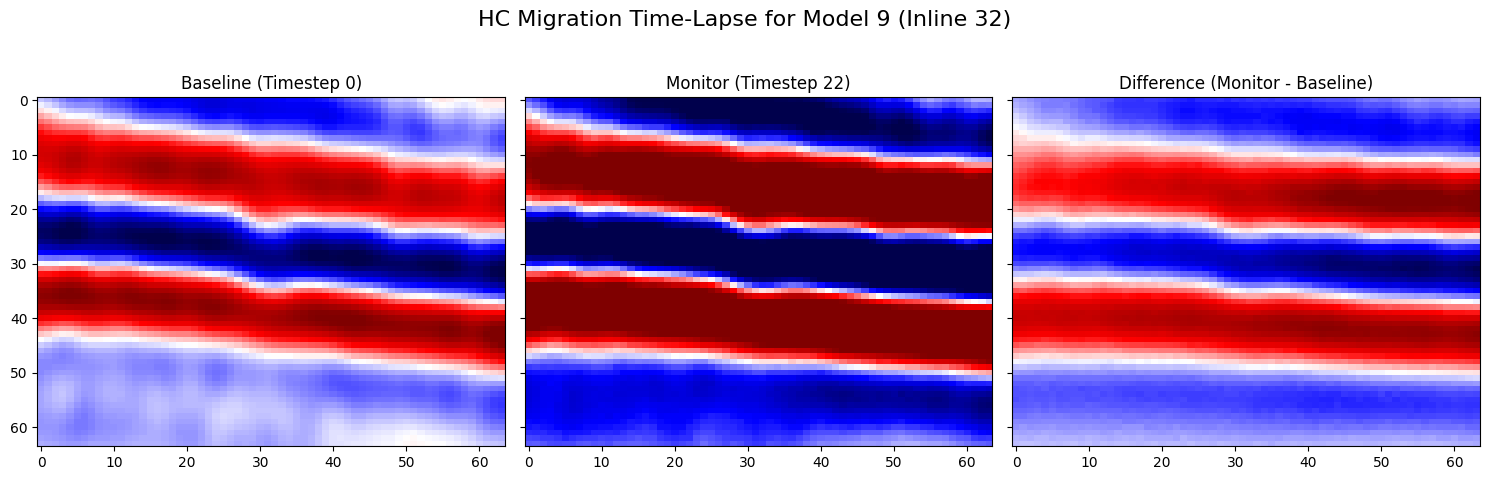

Button(button_style='success', description='Save to PDF', style=ButtonStyle())

Figure saved to: /content/drive/MyDrive/SeismicWorld/dataset/OIL/hc_model_9_timelapse_comparison.pdf


In [ ]:
#@title 绘制SCI论文图-oil production
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# This helper function is adapted to find the specific metadata for a model index.
def load_single_model_meta(log_path, model_index):
    """Loads the metadata for a specific model_index from the JSONL log file."""
    if not os.path.exists(log_path):
        print(f"Error: Log file not found at {log_path}")
        return None
    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                meta = json.loads(line)
                # Find the line corresponding to the exact model index
                if meta.get("model_index") == model_index and "error" not in meta:
                    return meta
            except json.JSONDecodeError:
                continue # Ignore malformed lines
    return None


def plot_timelapse_comparison(output_root, model_index, slice_type='inline'):
    """
    Loads a single hydrocarbon migration model and creates a 3-panel plot showing
    the baseline, final timestep, and the difference, with a button to save as PDF.

    Args:
        output_root (str): The root directory where the dataset is saved (e.g., ".../dataset/OIL").
        model_index (int): The index of the model to plot.
        slice_type (str): The type of slice to plot ('inline' or 'xline').
    """
    log_path = os.path.join(output_root, "hc_meta_log.jsonl") # Using the new log file
    meta = load_single_model_meta(log_path, model_index)

    if not meta:
        print(f"Error: Metadata for model {model_index} not found in {log_path}")
        return

    # Using the new file prefix for the hydrocarbon models
    prefix = f"hc_model_{model_index:05d}"
    save_format = meta.get('save_format', 'bin')

    try:
        # --- Load the seismic data cube ---
        # The loading logic remains the same, just the filenames change
        if save_format == 'bin':
            seismic_path = os.path.join(output_root, f"{prefix}_seismic.bin")
            seismic_shape = tuple(meta['shapes']['seismic']) # Reading shape from metadata
            seismic_data = np.fromfile(seismic_path, dtype=np.float32).reshape(seismic_shape)
        elif save_format == 'npz':
            npz_path = os.path.join(output_root, f"{prefix}.npz")
            with np.load(npz_path) as data:
                seismic_data = data['seismic']
        else:
            raise ValueError(f"Unsupported save_format: {save_format}")

        nt, ny, nx, nz = seismic_data.shape
        if nt < 2:
            print(f"Model {model_index} has only {nt} timestep(s). Cannot create a time-lapse comparison.")
            return

        # --- Get baseline, monitor, and difference data ---
        baseline = seismic_data[0]
        monitor = seismic_data[-1]
        difference = monitor - baseline

        # --- Extract the specific slice from each cube ---
        if slice_type == 'inline':
            slice_idx = ny // 2
            baseline_slice = baseline[slice_idx, :, :].T
            monitor_slice = monitor[slice_idx, :, :].T
            difference_slice = difference[slice_idx, :, :].T
            slice_title_str = f"Inline {slice_idx}"
        elif slice_type == 'xline':
            slice_idx = nx // 2
            baseline_slice = baseline[:, slice_idx, :].T
            monitor_slice = monitor[:, slice_idx, :].T
            difference_slice = difference[:, slice_idx, :].T
            slice_title_str = f"Crossline {slice_idx}"
        else:
            raise ValueError("slice_type must be 'inline' or 'xline'")


        # --- Plotting ---
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

        vmax = np.percentile(np.abs(baseline_slice), 99)
        if vmax < 1e-9: vmax = 1.0
        diff_vmax = np.percentile(np.abs(difference_slice), 99)
        if diff_vmax < 1e-9: diff_vmax = 1.0

        axes[0].imshow(baseline_slice, cmap='seismic', vmin=-vmax, vmax=vmax, aspect='auto')
        axes[0].set_title(f'Baseline (Timestep 0)')

        axes[1].imshow(monitor_slice, cmap='seismic', vmin=-vmax, vmax=vmax, aspect='auto')
        axes[1].set_title(f'Monitor (Timestep {nt-1})')

        axes[2].imshow(difference_slice, cmap='seismic', vmin=-diff_vmax, vmax=diff_vmax, aspect='auto')
        axes[2].set_title('Difference (Monitor - Baseline)')

        fig.suptitle(f'HC Migration Time-Lapse for Model {model_index} ({slice_title_str})', fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        # --- Create and display the save button ---
        save_button = widgets.Button(description="Save to PDF", button_style='success')

        def on_save_button_clicked(b):
            pdf_filename = os.path.join(output_root, f"hc_model_{model_index}_timelapse_comparison.pdf")
            fig.savefig(pdf_filename, format='pdf', bbox_inches='tight')
            print(f"Figure saved to: {pdf_filename}")

        save_button.on_click(on_save_button_clicked)

        plt.show()
        display(save_button)

    except (FileNotFoundError, ValueError, KeyError) as e:
        print(f"An error occurred while processing model {model_index}: {e}")
        import traceback
        traceback.print_exc()


# --- Example on how to call the function for your OIL dataset ---
# Make sure this path points to your new oil dataset directory
output_root_oil = "/content/drive/MyDrive/SeismicWorld/dataset/OIL"

# Plot a comparison for a single model from your new dataset
plot_timelapse_comparison(
    output_root=output_root_oil,
    model_index=9,  # Choose any model index you generated (e.g., 0 to 9)
    slice_type='inline'
)


# 只生成地震体

In [ ]:
# -*- coding: utf-8 -*-
"""
修改说明:
1. 原本保存全时序地震数据 seismic.shape = (nt, ny, nx, nz)
2. 现在只保存首末时刻两帧: seismic_reduced.shape = (2, ny, nx, nz)
   顺序: [0] = baseline, [1] = final
3. meta 中增加字段: full_nt (完整时间步数), saved_seismic_nt=2
4. 若需要差分，可在标注位置取消注释
"""

import os, json, math, time, gc, random, traceback
import numpy as np
from tqdm import tqdm
from datetime import datetime
from pathlib import Path

############################################
# 全局配置区（可通过UI参数调整）
############################################
output_root = "/content/drive/MyDrive/SeismicWorld/dataset/CO2"  #@param {type:"string"}
os.makedirs(output_root, exist_ok=True)

save_format = "bin"  #@param ["bin", "npz"] {allow-input: true}

total_models = 20              #@param {type:"integer"}
model_index_start = 10             #@param {type:"integer"}
small_run = False                 #@param {type:"boolean"}

nt_min, nt_max = 6, 10            #@param {type:"raw"}

global_seed = 2025                #@param {type:"integer"}

inline_quick_plot = False         #@param {type:"boolean"}
save_gravity_magnetic_each_step = True  #@param {type:"boolean"}
npz_compress = True               #@param {type:"boolean"}

gravity_height_range = (0.0, 150.0)      #@param {type:"raw"}
mag_height_range    = (5.0, 50.0)        #@param {type:"raw"}
padding_factor_choices = [1, 2]          #@param {type:"raw"}

memory_soft_limit_gb = 20   #@param {type:"number"}

############################################
# 依赖你的 GeoModel 类 (假设已在运行环境里可用)
# from your_module import GeoModel
############################################

def sample_velocity_params(rng: random.Random):
    h_layer_scale = rng.uniform(0.04, 0.09)
    h_layer_range = [60 * rng.uniform(0.8,1.2), 120 * rng.uniform(0.8,1.2)]
    vp_list = [
        (rng.uniform(2800,3200), rng.uniform(3400,3800)),
        (rng.uniform(3600,4000), rng.uniform(4500,5200)),
        (rng.uniform(5000,5600), rng.uniform(6000,6500))
    ]
    vp_diff = rng.uniform(400, 600)
    vp_disturb = rng.uniform(200, 400)
    return dict(h_layer_range=h_layer_range,
                fm_list=[0.3, 0.6],
                vp_list=vp_list,
                vp_diff=vp_diff,
                vp_disturb=vp_disturb,
                smooth=False)

def sample_channel_params(rng, model_index=None):
    PROB_TIER_B = 0.18
    PROB_TIER_C = 0.08
    PROB_TIER_D = 0.02
    PROB_AGGR    = 0.03
    PROB_MULTI_N = 0.04
    INCISION_MODES = ["random", 1, 2]

    if not hasattr(sample_channel_params, "_counter"):
        sample_channel_params._counter = 0
    if model_index is None:
        idx = sample_channel_params._counter
        sample_channel_params._counter += 1
    else:
        idx = model_index

    width_classes = [
        ((120, 180), (12, 18)),
        ((180, 260), (16, 24)),
        ((260, 340), (18, 28)),
        ((150, 220), (14, 22)),
    ]
    wc = width_classes[idx % len(width_classes)]
    W_range, D_range = wc

    expand_scale_w = rng.uniform(1.2, 1.6)
    expand_scale_d = rng.uniform(1.05, 1.3)
    Wx_range = (int(W_range[0] * expand_scale_w), int(W_range[1] * expand_scale_w))
    Dx_range = (int(D_range[0] * expand_scale_d), int(D_range[1] * expand_scale_d))

    sinuosity_classes = [
        ((35, 45), (0.03, 0.05), (0.25, 0.35)),
        ((40, 55), (0.05, 0.07), (0.30, 0.45)),
        ((50, 70), (0.06, 0.09), (0.40, 0.55)),
    ]
    sc = sinuosity_classes[(idx // len(width_classes)) % len(sinuosity_classes)]
    kl_range, Cf_range, epsilon_range = sc

    vert_bucket = (idx // (len(width_classes) * len(sinuosity_classes))) % 3
    if vert_bucket == 0:
        Z_pos_range = [0.25, 0.45]
    elif vert_bucket == 1:
        Z_pos_range = [0.45, 0.65]
    else:
        Z_pos_range = [0.65, 0.85]

    Y_center = rng.uniform(0.15, 0.85)
    span = rng.uniform(0.15, 0.35)
    y0 = max(0.0, Y_center - span/2)
    y1 = min(1.0, Y_center + span/2)
    Y_pos_range = [y0, y1]

    X_pos_range = [0.0, rng.uniform(0.03, 0.08)]

    r = rng.random()
    if r < PROB_TIER_D:
        n_iter_range = [20, 30]
    elif r < PROB_TIER_D + PROB_TIER_C:
        n_iter_range = [8, 15]
    elif r < PROB_TIER_D + PROB_TIER_C + PROB_TIER_B:
        n_iter_range = [3, 6]
    else:
        n_iter_range = [1, 1]

    if rng.random() < PROB_AGGR and n_iter_range[1] > 1:
        kv = rng.uniform(0.02, 0.10)
        aggr = rng.uniform(0.01, 0.06)
    else:
        kv = 0
        aggr = 0

    if rng.random() < PROB_MULTI_N and n_iter_range[0] == 1:
        N = 2
    else:
        N = 1

    incision_mode = INCISION_MODES[idx % len(INCISION_MODES)]

    strike_base = (idx * 37) % 360
    strike_span = rng.uniform(40, 120)
    strike_min = (strike_base - strike_span/2) % 360
    strike_max = (strike_base + strike_span/2) % 360
    strike_range = [strike_min, strike_max]

    save_iter = int(1e9)

    params = dict(
        N=N,
        X_pos_range=X_pos_range,
        Y_pos_range=Y_pos_range,
        Z_pos_range=Z_pos_range,
        strike_range=strike_range,
        W_range=[int(W_range[0]), int(W_range[1])],
        D_range=[int(D_range[0]), int(D_range[1])],
        Wx_range=[int(Wx_range[0]), int(Wx_range[1])],
        Dx_range=[int(Dx_range[0]), int(Dx_range[1])],
        kl_range=[int(kl_range[0]), int(kl_range[1])],
        Cf_range=[float(f"{Cf_range[0]:.3f}"), float(f"{Cf_range[1]:.3f}")],
        n_iter_range=[int(n_iter_range[0]), int(n_iter_range[1])],
        epsilon_range=[float(f"{epsilon_range[0]:.3f}"), float(f"{epsilon_range[1]:.3f}")],
        incision_mode=incision_mode,
        kv=kv,
        aggr=aggr,
        save_iter=save_iter,
        show_migration=False,
        seed=None,
        instance_label=False,
        mute=True
    )
    return params

def sample_density_params(rng: random.Random):
    channel_density_contrast = (rng.uniform(-0.15,-0.05), rng.uniform(0.02,0.08))
    return dict(method='gardner',
                params={'a':0.31,'b':0.25},
                channel_density_contrast=channel_density_contrast,
                mute=True)

def sample_magnetic_params(rng: random.Random, horizons):
    if len(horizons) >= 2:
        fm_list = [0.3 + rng.uniform(-0.02,0.02), 0.6 + rng.uniform(-0.02,0.02)]
        fm_list = [max(0.05,min(0.9,v)) for v in fm_list]
    else:
        fm_list = [0.4, 0.7]

    k_list = [
        (rng.uniform(3e-5,7e-5),  rng.uniform(1e-4,2.5e-4)),
        (rng.uniform(1.5e-4,3e-4),rng.uniform(5e-4,9e-4)),
        (rng.uniform(7e-4,1.5e-3),rng.uniform(2e-3,3.5e-3))
    ]
    facies_k = {
        1: (1e-5, 5e-5),
        2: (1e-4, 8e-4),
        3: (2e-4, 1e-3),
        4: (1e-5, 2e-5)
    }
    return dict(
        kappa_list=k_list,
        fm_list=fm_list,
        kappa_disturb=rng.uniform(5e-5,2e-4),
        facies_kappa=facies_k,
        background_kappa=(2e-5,1e-4),
        smooth=True,
        sigma=rng.uniform(1.0,2.0),
        seed=None,
        mute=True
    )

def sample_co2_timelapse_params(rng: random.Random, nt):
    assert nt >= 2
    mode = rng.choice(['linear','quadratic','jitter'])
    if mode == 'linear':
        base = np.linspace(0.1, 0.9, nt, dtype=np.float32)
    elif mode == 'quadratic':
        x = np.linspace(0, 1, nt, dtype=np.float32)
        base = 0.1 + 0.8 * (x**2)
    else:
        increments = [np.clip(rng.normalvariate(0.15, 0.03), 0.05, 0.25) for _ in range(nt)]
        base = np.cumsum(increments).astype(np.float32)
        m = float(base.max())
        if m <= 1e-9:
            base = np.linspace(0.05, 1.0, nt, dtype=np.float32)
            m = 1.0
        base = 0.1 + 0.8 * (base / m)
    base = np.clip(base, 0.05, 0.95)
    injection_rates = base.tolist()
    return dict(
        injection_rates=injection_rates,
        co2_saturation_effect = rng.uniform(0.25, 0.5),
        pressure_buildup_coefficient = rng.uniform(0.05, 0.5),
        co2_density_contrast = rng.uniform(-0.5, -0.2),
        tuning_thickness_factor = rng.uniform(2.0, 4.5),
        lateral_diffusion_range = rng.uniform(50, 120),
        vertical_migration_factor = rng.uniform(0.2, 0.6),
        noise_level = rng.uniform(0.01, 0.03),
        wavelet_type='ricker',
        f_ricker=rng.uniform(20, 35),
        dt=0.002,
        seed=None,
        visualize_results=False
    )

def estimate_memory_per_model(ny,nx,nz,nt, n_fields=6):
    return nt*ny*nx*nz*4*n_fields / (1024**3)

############################################
# 主处理函数
############################################
def build_co2_dataset(total_models,
                      model_index_start=0,
                      save_format='bin',
                      small_run=False,
                      quick_plot=False,
                      fast_mode=False):
    rng_global = random.Random(global_seed)

    if small_run:
        total_models = min(total_models, 3)

    log_path = os.path.join(output_root, "meta_log.jsonl")
    meta_f = open(log_path, 'a', encoding='utf-8')
    print(f"[INFO] 日志写入: {log_path}")

    failed = []
    success = 0
    t0_all = time.time()

    for mid in tqdm(range(model_index_start, model_index_start+total_models), desc="批量建模"):
        t0 = time.time()
        model_seed = global_seed + mid
        rng = random.Random(model_seed)

        try:
            xmin,xmax,dx = 0, 6400, 100
            ymin,ymax,dy = 0, 6400, 100
            zmin,zmax,dz = 0, 1500, 20
            gm = GeoModel(extent=[xmin,xmax,ymin,ymax,zmin,zmax],
                          resolution=[dx,dy,dz],
                          mute=True)

            vp_params = sample_velocity_params(rng)
            gm.add_vp(**vp_params, seed=model_seed, mute=True)
            gm.add_rgt(mute=True)

            gm.add_dipping(a_range=[0.01,0.04], b_range=[0.01,0.04],
                           seed=model_seed, mute=True)
            gm.add_fold(N=10, sigma_range=[0.10,0.15], A_range=[0.02,0.04],
                        d_fold=3000, seed=model_seed, mute=True)

            ch_params = sample_channel_params(rng)
            gm.add_meandering_channel(**ch_params)

            den_params = sample_density_params(rng)
            gm.add_density_model(**den_params)

            mag_params = sample_magnetic_params(rng, gm.horizon)
            gm.add_magnetic_susceptibility(**mag_params)

            g_height = rng.uniform(*gravity_height_range)
            m_height = rng.uniform(*mag_height_range)
            pad_fac = rng.choice(padding_factor_choices)

            gm.compute_gravity(height=g_height,
                               padding_factor=pad_fac,
                               mute=True)

            gm.compute_magnetic_anomaly_3d(height=m_height,
                                           inclination=60.0,
                                           declination=5.0,
                                           intensity=50000.0,
                                           padding_factor=pad_fac,
                                           mute=True)

            gm.smooth(param=['vp','channel'], sigma=1.5)
            gm.resample_z(param='all', z_range=(200,1480), mute=True)

            gm.compute_Ip(rho=2.4)
            gm.compute_rc(mute=True)
            gm.make_synseis(f_ricker=25, mark_channel=True, mute=True)

            nt = rng.randint(nt_min, nt_max)
            tl_params = sample_co2_timelapse_params(rng, nt)

            if fast_mode:
                co2_data = gm.simulate_co2_storage_timelapse_fast(
                    injection_rates = tl_params['injection_rates'],
                    co2_saturation_effect = tl_params['co2_saturation_effect'],
                    pressure_buildup_coefficient = tl_params['pressure_buildup_coefficient'],
                    co2_density_contrast = tl_params['co2_density_contrast'],
                    tuning_thickness_factor = tl_params['tuning_thickness_factor'],
                    noise_level = tl_params['noise_level'],
                    wavelet_type = tl_params['wavelet_type'],
                    f_ricker = tl_params['f_ricker'],
                    dt = tl_params['dt'],
                    seed = tl_params['seed'],
                    compute_potential = 'final'
                )
            else:
                co2_data = gm.simulate_co2_storage_timelapse(**tl_params)

            # ========== 只保留首末地震 ==========
            full_nt = len(co2_data)
            # 原全时序 (不再全部保存):
            full_seismic = np.array([d['seismic'] for d in co2_data], dtype=np.float32)
            # 取首末
            seismic = np.stack([full_seismic[0], full_seismic[-1]], axis=0)  # shape (2, ny, nx, nz)

            # 若需要差分 (final - first) 取消下一行注释:
            # seismic_diff = (full_seismic[-1] - full_seismic[0]).astype(np.float32)

            vp_seq  = np.array([d['vp']      for d in co2_data], dtype=np.float32)
            sat_seq = np.array([d['co2_saturation'] for d in co2_data], dtype=np.float32)
            pres_seq= np.array([d['pressure_change'] for d in co2_data], dtype=np.float32)
            tune_seq= np.array([d['tuning_effect']   for d in co2_data], dtype=np.float32)

            if save_gravity_magnetic_each_step:
                gravity_seq = []
                magnetic_seq = []
                for d in co2_data:
                    gravity_seq.append(d.get('gravity_anomaly', gm.gravity if hasattr(gm,'gravity') else np.zeros((gm.nX,gm.nY))))
                    magnetic_seq.append(d.get('magnetic_anomaly', gm.magnetic_anomaly if hasattr(gm,'magnetic_anomaly') else np.zeros((gm.nX,gm.nY))))
                gravity_seq = np.array(gravity_seq, dtype=np.float32)
                magnetic_seq= np.array(magnetic_seq, dtype=np.float32)
            else:
                gravity_seq = np.array([gm.gravity], dtype=np.float32)
                magnetic_seq= np.array([gm.magnetic_anomaly], dtype=np.float32)

            prefix = f"co2_model_{mid:05d}"
            shapes = {
                "saved_seismic_shape": seismic.shape,   # (2, ny, nx, nz)
                "full_nt": full_nt,
                "vp_shape": vp_seq.shape,
                "sat_shape": sat_seq.shape,
                "pressure_shape": pres_seq.shape,
                "tuning_shape": tune_seq.shape,
                "gravity_shape": gravity_seq.shape,
                "magnetic_shape": magnetic_seq.shape
            }

            if save_format == 'bin':
                seismic.tofile(os.path.join(output_root, f"{prefix}_seismic_first_last.bin"))
                # 如果要保存差分:
                # seismic_diff.tofile(os.path.join(output_root, f"{prefix}_seismic_diff.bin"))
                vp_seq.tofile(os.path.join(output_root, f"{prefix}_vp.bin"))
                sat_seq.tofile(os.path.join(output_root, f"{prefix}_saturation.bin"))
                pres_seq.tofile(os.path.join(output_root, f"{prefix}_pressure.bin"))
                tune_seq.tofile(os.path.join(output_root, f"{prefix}_tuning.bin"))
                gravity_seq.tofile(os.path.join(output_root, f"{prefix}_gravity.bin"))
                magnetic_seq.tofile(os.path.join(output_root, f"{prefix}_magnetic.bin"))
            else:
                comp = dict(compression='zip') if npz_compress else {}
                np.savez(os.path.join(output_root, f"{prefix}.npz"),
                         seismic_first_last=seismic,
                         # seismic_diff=seismic_diff,  # 若需要差分取消注释
                         vp=vp_seq,
                         saturation=sat_seq,
                         pressure=pres_seq,
                         tuning=tune_seq,
                         gravity=gravity_seq,
                         magnetic=magnetic_seq,
                         **comp)

            meta = {
                "model_index": mid,
                "seed": model_seed,
                "time": datetime.utcnow().isoformat(),
                "grid": {"nx":gm.nX,"ny":gm.nY,"nz":gm.nZ,"dx":gm.dX,"dy":gm.dY,"dz":gm.dZ},
                "full_nt": full_nt,
                "saved_seismic_nt": 2,
                "obs": {
                    "gravity_height": g_height,
                    "mag_height": m_height,
                    "padding_factor": pad_fac
                },
                "vp_params": vp_params,
                "channel_params": {k:v for k,v in ch_params.items() if k not in ['seed']},
                "density_params": den_params,
                "mag_params": {k:v for k,v in mag_params.items() if k not in ['seed']},
                "co2_params": tl_params,
                "shapes": shapes,
                "save_format": save_format
            }
            meta_f.write(json.dumps(meta, ensure_ascii=False)+'\n')
            meta_f.flush()

            success += 1

            if quick_plot or (inline_quick_plot and mid == model_index_start):
                import matplotlib.pyplot as plt
                inline_idx = seismic.shape[1] // 2
                fig, ax = plt.subplots(2,4, figsize=(14,6))
                vmax0 = np.max(np.abs(seismic[0,inline_idx])) * 0.9
                vmax1 = np.max(np.abs(seismic[1,inline_idx])) * 0.9
                ax[0,0].imshow(seismic[0,inline_idx].T, cmap='seismic', vmin=-vmax0, vmax=vmax0, aspect='auto'); ax[0,0].set_title("Baseline Seis")
                ax[0,1].imshow(seismic[1,inline_idx].T, cmap='seismic', vmin=-vmax1, vmax=vmax1, aspect='auto'); ax[0,1].set_title("Final Seis")
                diff = (seismic[1,inline_idx]-seismic[0,inline_idx])
                dv = np.max(np.abs(diff))*0.9
                ax[0,2].imshow(diff.T, cmap='seismic', vmin=-dv, vmax=dv, aspect='auto'); ax[0,2].set_title("Diff Final-Baseline")
                ax[0,3].imshow(sat_seq[-1,inline_idx].T, cmap='Blues', aspect='auto'); ax[0,3].set_title("Final CO2 Sat")
                ax[1,0].imshow(pres_seq[-1,inline_idx].T, cmap='RdBu_r', aspect='auto'); ax[1,0].set_title("Final Pressure")
                ax[1,1].imshow(tune_seq[-1,inline_idx].T, cmap='viridis', aspect='auto'); ax[1,1].set_title("Final Tuning")
                ax[1,2].imshow(gravity_seq[-1], cmap='seismic', aspect='auto'); ax[1,2].set_title("Gravity (mGal)")
                ax[1,3].imshow(magnetic_seq[-1], cmap='seismic', aspect='auto'); ax[1,3].set_title("Mag (nT)")
                plt.suptitle(f"Quick Inspect Model {mid}")
                plt.tight_layout()
                plt.show()

            del (gm, seismic, full_seismic, vp_seq, sat_seq, pres_seq, tune_seq,
                 gravity_seq, magnetic_seq)
            gc.collect()

        except Exception as e:
            failed.append(mid)
            traceback.print_exc()
            meta_f.write(json.dumps({"model_index": mid, "seed": model_seed, "error": str(e)})+'\n')
            meta_f.flush()
            continue

        dt_model = time.time() - t0
        if not small_run:
            print(f"[MODEL {mid}] Done in {dt_model:.1f}s (saved first & last seismic)")

    meta_f.close()
    dt_all = time.time() - t0_all
    print(f"\n=== 运行完成 ===")
    print(f"成功: {success} / {total_models} 失败: {len(failed)} 耗时: {dt_all/60:.1f} min")
    if failed:
        print("失败索引:", failed)

    return {"success":success, "failed":failed}

# 执行数据集构建
stats = build_co2_dataset(total_models=total_models,
                          model_index_start=model_index_start,
                          save_format=save_format,
                          small_run=small_run,
                          quick_plot=False)
print("统计:", stats)


[INFO] 日志写入: /content/drive/MyDrive/SeismicWorld/dataset/CO2/meta_log.jsonl


批量建模:   0%|          | 0/20 [00:00<?, ?it/s]

Smoothing Vp model... Done.
Smoothing channel label... Done.
Generating baseline seismic data for CO2 storage simulation...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 1/8 with injection rate 0.10...































































Generating CO2 time-lapse seismic data for step 1...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 2/8 with injection rate 0.12...































































Generating CO2 time-lapse seismic data for step 2...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 3/8 with injection rate 0.17...































































Generating CO2 time-lapse seismic data for step 3...
Generating synthetic seismic data: 100.00%
Simulating CO2 storage step 4/8 with injection rate 0.25...































































Generating CO2 time-lapse seismic data for step 4...


批量建模:   0%|          | 0/20 [00:06<?, ?it/s]

Generating CO2 time-lapse seismic data for step 6...
Generating synthetic seismic data: 90.80%

KeyboardInterrupt: 